In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [500]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.svm import SVR
import xgboost as xgb
from tensorflow.keras.layers import LSTM, Dense, GRU


In [501]:
def linegraph(train_dates, y_train, test_dates, y_test, predictions):
    train = pd.DataFrame({
        'Date': train_dates,
        'Close': y_train
    })
    valid = pd.DataFrame({
        'Date': test_dates,
        'Close': y_test,
        'Predictions': predictions
    })

    # Visualize the data
    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Validation')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()

# Random Forest

In [502]:
def run_random_forest(DF, n_estimators, random_state,Features, Target):
  
    features = Features
    target = Target
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        DF[features + ['Date']],
        DF[target],
        test_size=0.2,
        random_state=random_state,
        shuffle=False
    )
    
    # Saving the 'Date' column for potential use and then dropping it from training and testing datasets
    train_dates = X_train['Date']
    test_dates = X_test['Date']
    X_train.drop(['Date'], axis=1, inplace=True)
    X_test.drop(['Date'], axis=1, inplace=True)
    
    # Creating and fitting the RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Making predictions
    predictions = rf_model.predict(X_test)
    
    # Evaluating the model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    # Print results
    print(f'Mean Squared Error: {mse:.3f}')
    print(f'Root Mean Squared Error: {rmse:.3f}')
    print(f'R-squared Score: {r2:.3f}')
    linegraph(train_dates, y_train, test_dates, y_test, predictions)
    # Optionally, return these metrics if you want to use them later
    return mse, rmse, r2

# SVR

In [503]:
def run_svr(Df, random_state, Features, Target):
    DF = Df
    features = Features
    target = Target
    dates = DF['Date'].values  
    
    # Initialize separate scalers for features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Scale features and target separately
    DF_features_scaled = feature_scaler.fit_transform(DF[features])
    DF_target_scaled = target_scaler.fit_transform(DF[[target]]) 
    
    sequence_length = 10
    X, y, X_dates = [], [], []
    for i in range(len(DF_features_scaled) - sequence_length):
        X.append(DF_features_scaled[i:(i + sequence_length), :])
        y.append(DF_target_scaled[i + sequence_length, 0])
        X_dates.append(dates[i + sequence_length])
    
    X, y, X_dates = np.array(X), np.array(y), np.array(X_dates)
    
    # Splitting dataset
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    train_dates, test_dates = X_dates[:train_size], X_dates[train_size:]
    
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    svr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

    y_pred = svr_model.predict(X_test.reshape(X_test.shape[0], -1))

    # Inverse transform the predictions and actuals using the correct scaler
    y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
   
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')

# LSTM

In [504]:
def LSTM_Model(dataFrame,Features, Target, epochs, batch_size):
    DF=dataFrame
    features = Features
    target=Target
    dates = DF['Date'].values
    print(features)
    print(target)
    print(epochs)
    print(batch_size)
    # Data scaling
    scaler = MinMaxScaler()
    DF_scaled = scaler.fit_transform(DF[features + [target]])
    
    # Preparing input sequences
    sequence_length = 10
    X, y, X_dates = [], [], []
    for i in range(len(DF_scaled) - sequence_length):
        X.append(DF_scaled[i:(i + sequence_length), :-1])
        y.append(DF_scaled[i + sequence_length, -1])
        X_dates.append(dates[i + sequence_length])
    X, y, X_dates = np.array(X), np.array(y), np.array(X_dates)
    y = y.reshape(-1, 1)
    
    # Splitting dataset
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    train_dates, test_dates = X_dates[:train_size], X_dates[train_size:]
    
    # Model building
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Model training
    model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2)
    
    # Model prediction
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :].reshape(X_test.shape[0], -1)
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    y_test_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_test.reshape(-1, 1)), axis=1))[:, -1]
    train_inv_y = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]
    
    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    # Print results
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')
    
    return train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv

# Gated Recurrent Units GRU

In [505]:
def GRU_Model(dataFrame,Features, Target, epochs, batch_size):
    TestDF = dataFrame
    target = Target
    features = Features
    print(features)
    print(target)
    print(epochs)
    print(batch_size)
    scaler = MinMaxScaler()
    TestDF[features] = scaler.fit_transform(TestDF[features])
    TestDF[target] = scaler.fit_transform(TestDF[[target]])
    def create_sequences(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X.iloc[i:(i + time_steps)].values)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10

    X, y = create_sequences(TestDF[features], TestDF[target], time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, shuffle=False)

    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        GRU(50),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rescaled, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_rescaled, predictions)

    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')

# XGBoost

In [506]:
def run_xgboost(Data, Features, Target, random_state):
    
    DF = Data
    features = Features
    target = Target
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        DF[features + ['Date']],
        DF[target],
        test_size=0.2,
        random_state=random_state,
        shuffle=False
    )
    
    train_dates = X_train['Date']
    test_dates = X_test['Date']
    X_train.drop(['Date'], axis=1, inplace=True)
    X_test.drop(['Date'], axis=1, inplace=True)
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)
    linegraph(train_dates, y_train, test_dates, y_test, y_pred)

In [507]:
Data = pd.read_csv("Data2/AMCL(PRAN)_data.csv")

In [508]:
Data.head()

,Date,Open,High,Low,Close,Volume
0,10/01/2012,139.0,142.0,137.0,139.4,12000
1,10/02/2012,140.1,141.5,138.6,140.0,10500
2,10/03/2012,140.5,142.0,140.0,140.4,12100
3,10/04/2012,143.8,143.8,138.2,139.3,11600
4,10/07/2012,140.0,140.0,132.0,134.6,2100


In [509]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2625 non-null   object 
 1   Open    2624 non-null   float64
 2   High    2623 non-null   float64
 3   Low     2624 non-null   float64
 4   Close   2623 non-null   float64
 5   Volume  2625 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 123.2+ KB


In [510]:
Data['Date'] = pd.to_datetime(Data['Date'])

In [511]:
Data.head()

,Date,Open,High,Low,Close,Volume
0,2012-10-01,139.0,142.0,137.0,139.4,12000
1,2012-10-02,140.1,141.5,138.6,140.0,10500
2,2012-10-03,140.5,142.0,140.0,140.4,12100
3,2012-10-04,143.8,143.8,138.2,139.3,11600
4,2012-10-07,140.0,140.0,132.0,134.6,2100


In [512]:
Data = Data[Data['Date'] >= '2021-01-01']

In [513]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 1913 to 2624
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    712 non-null    datetime64[ns]
 1   Open    711 non-null    float64       
 2   High    710 non-null    float64       
 3   Low     711 non-null    float64       
 4   Close   710 non-null    float64       
 5   Volume  712 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 38.9 KB


In [514]:
Data.describe()

,Date,Open,High,Low,Close,Volume
count,712,711.000000,710.000000,711.000000,710.000000,712.000000
mean,2022-07-08 02:57:58.651685376,263.390929,267.787502,258.804326,262.252921,43205.188202
min,2021-01-03 00:00:00,180.200000,183.000000,180.200000,183.000000,1.000000
25%,2021-10-13 18:00:00,233.500000,239.750000,227.700000,234.850000,6605.000000
50%,2022-07-05 12:00:00,266.304286,269.889286,263.300000,265.450000,21791.000000
75%,2023-04-10 06:00:00,282.050000,286.900000,274.501786,280.225000,56426.500000
max,2024-01-04 00:00:00,394.800000,399.000000,375.000000,395.700000,510410.000000
std,NaN,47.043952,48.965477,44.633637,46.269303,58902.252566


In [515]:
def fill_missing_with_mean(df):
    result = df.copy()
    for i in range(len(df)):
        if pd.isnull(df.iloc[i]):
            prev_index = i - 1
            next_index = i + 1
            while pd.isnull(df.iloc[prev_index]):
                prev_index -= 1
            while pd.isnull(df.iloc[next_index]):
                next_index += 1
            prev_val = df.iloc[prev_index] if prev_index >= 0 else np.nan
            next_val = df.iloc[next_index] if next_index < len(df) else np.nan
            if pd.notnull(prev_val) and pd.notnull(next_val):
                result.iloc[i] = (prev_val + next_val) / 2
    return result

# Feature Engineering

In [516]:
Data.set_index('Date', inplace=True)

In [517]:
all_dates = pd.date_range(start=Data.index.min(), end=Data.index.max(), freq='D')

In [518]:
Data = Data.reindex(all_dates)

In [519]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,195.1,197.0,194.5,195.8,6809.0
2021-01-04,197.8,199.0,197.0,197.7,4473.0
2021-01-05,195.0,199.0,195.0,197.7,2974.0
2021-01-06,202.5,202.5,196.5,197.3,7801.0
2021-01-07,200.0,200.0,197.5,197.8,5833.0
2021-01-08,NaN,NaN,NaN,NaN,NaN
2021-01-09,NaN,NaN,NaN,NaN,NaN
2021-01-10,198.1,199.0,196.8,197.4,3271.0
2021-01-11,197.2,197.6,193.0,193.7,7272.0
2021-01-12,195.1,200.0,195.1,199.3,6674.0


In [520]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2021-01-03 to 2024-01-04
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    711 non-null    float64
 1   High    710 non-null    float64
 2   Low     711 non-null    float64
 3   Close   710 non-null    float64
 4   Volume  712 non-null    float64
dtypes: float64(5)
memory usage: 51.4 KB


In [521]:
Df = fill_missing_with_mean(Data['Open'])
Data['Open'] = Df

In [522]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,195.10,197.0,194.5,195.8,6809.0
2021-01-04,197.80,199.0,197.0,197.7,4473.0
2021-01-05,195.00,199.0,195.0,197.7,2974.0
2021-01-06,202.50,202.5,196.5,197.3,7801.0
2021-01-07,200.00,200.0,197.5,197.8,5833.0
2021-01-08,199.05,NaN,NaN,NaN,NaN
2021-01-09,199.05,NaN,NaN,NaN,NaN
2021-01-10,198.10,199.0,196.8,197.4,3271.0
2021-01-11,197.20,197.6,193.0,193.7,7272.0
2021-01-12,195.10,200.0,195.1,199.3,6674.0


In [523]:
Df = fill_missing_with_mean(Data['High'])
Data['High'] = Df

In [524]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,195.10,197.00,194.5,195.8,6809.0
2021-01-04,197.80,199.00,197.0,197.7,4473.0
2021-01-05,195.00,199.00,195.0,197.7,2974.0
2021-01-06,202.50,202.50,196.5,197.3,7801.0
2021-01-07,200.00,200.00,197.5,197.8,5833.0
2021-01-08,199.05,199.50,NaN,NaN,NaN
2021-01-09,199.05,199.50,NaN,NaN,NaN
2021-01-10,198.10,199.00,196.8,197.4,3271.0
2021-01-11,197.20,197.60,193.0,193.7,7272.0
2021-01-12,195.10,200.00,195.1,199.3,6674.0


In [525]:
Df = fill_missing_with_mean(Data['Low'])
Data['Low'] = Df

In [526]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,195.10,197.00,194.50,195.8,6809.0
2021-01-04,197.80,199.00,197.00,197.7,4473.0
2021-01-05,195.00,199.00,195.00,197.7,2974.0
2021-01-06,202.50,202.50,196.50,197.3,7801.0
2021-01-07,200.00,200.00,197.50,197.8,5833.0
2021-01-08,199.05,199.50,197.15,NaN,NaN
2021-01-09,199.05,199.50,197.15,NaN,NaN
2021-01-10,198.10,199.00,196.80,197.4,3271.0
2021-01-11,197.20,197.60,193.00,193.7,7272.0
2021-01-12,195.10,200.00,195.10,199.3,6674.0


In [527]:
Df = fill_missing_with_mean(Data['Close'])
Data['Close'] = Df

In [528]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,195.10,197.00,194.50,195.8,6809.0
2021-01-04,197.80,199.00,197.00,197.7,4473.0
2021-01-05,195.00,199.00,195.00,197.7,2974.0
2021-01-06,202.50,202.50,196.50,197.3,7801.0
2021-01-07,200.00,200.00,197.50,197.8,5833.0
2021-01-08,199.05,199.50,197.15,197.6,NaN
2021-01-09,199.05,199.50,197.15,197.6,NaN
2021-01-10,198.10,199.00,196.80,197.4,3271.0
2021-01-11,197.20,197.60,193.00,193.7,7272.0
2021-01-12,195.10,200.00,195.10,199.3,6674.0


In [529]:
Data['Volume'] = Data['Volume'].fillna(0)

In [530]:
Data.head(50)

,Open,High,Low,Close,Volume
2021-01-03,195.10,197.00,194.50,195.80,6809.0
2021-01-04,197.80,199.00,197.00,197.70,4473.0
2021-01-05,195.00,199.00,195.00,197.70,2974.0
2021-01-06,202.50,202.50,196.50,197.30,7801.0
2021-01-07,200.00,200.00,197.50,197.80,5833.0
2021-01-08,199.05,199.50,197.15,197.60,0.0
2021-01-09,199.05,199.50,197.15,197.60,0.0
2021-01-10,198.10,199.00,196.80,197.40,3271.0
2021-01-11,197.20,197.60,193.00,193.70,7272.0
2021-01-12,195.10,200.00,195.10,199.30,6674.0


In [531]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2021-01-03 to 2024-01-04
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1097 non-null   float64
 1   High    1097 non-null   float64
 2   Low     1097 non-null   float64
 3   Close   1097 non-null   float64
 4   Volume  1097 non-null   float64
dtypes: float64(5)
memory usage: 51.4 KB


In [532]:
Data.reset_index(inplace=True)
Data.rename(columns={'index': 'Date'}, inplace=True)

In [533]:
Data['day'] = Data['Date'].dt.day
Data['month'] = Data['Date'].dt.month
Data['year'] = Data['Date'].dt.year


Create column for 1 day, 1 week, 15 days, 1 month prediction of closing price

In [534]:
Data['1_day'] = Data['Close'].shift(-1)
Data['1_week'] = Data['Close'].shift(-7)
Data['15_days'] = Data['Close'].shift(-15)
Data['1_month'] = Data['Close'].shift(-30)

In [535]:
Data.head(30)

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
0,2021-01-03,195.10,197.00,194.50,195.80,6809.0,3,1,2021,197.70,197.40,196.50,194.80
1,2021-01-04,197.80,199.00,197.00,197.70,4473.0,4,1,2021,197.70,193.70,196.80,194.00
2,2021-01-05,195.00,199.00,195.00,197.70,2974.0,5,1,2021,197.30,199.30,195.30,194.30
3,2021-01-06,202.50,202.50,196.50,197.30,7801.0,6,1,2021,197.80,197.80,193.80,193.40
4,2021-01-07,200.00,200.00,197.50,197.80,5833.0,7,1,2021,197.60,200.20,193.50,193.40
5,2021-01-08,199.05,199.50,197.15,197.60,0.0,8,1,2021,197.60,199.40,193.50,192.50
6,2021-01-09,199.05,199.50,197.15,197.60,0.0,9,1,2021,197.40,199.40,193.20,192.90
7,2021-01-10,198.10,199.00,196.80,197.40,3271.0,10,1,2021,193.70,198.60,193.90,192.60
8,2021-01-11,197.20,197.60,193.00,193.70,7272.0,11,1,2021,199.30,196.50,193.80,193.20
9,2021-01-12,195.10,200.00,195.10,199.30,6674.0,12,1,2021,197.80,196.80,193.20,192.10


In [536]:
Data.describe()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
count,1097,1097.000000,1097.000000,1097.00000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1096.000000,1090.000000,1082.000000,1067.000000
mean,2022-07-05 00:00:00,262.059620,266.328361,257.61568,261.022966,28042.018232,15.698268,6.515953,2022.009116,261.082476,261.431829,261.899162,262.845542
min,2021-01-03 00:00:00,180.200000,183.000000,180.20000,183.000000,0.000000,1.000000,1.000000,2021.000000,183.000000,183.000000,183.000000,183.000000
25%,2021-10-04 00:00:00,223.800000,226.000000,217.00000,220.100000,0.000000,8.000000,4.000000,2021.000000,220.775000,225.975000,235.350000,243.050000
50%,2022-07-05 00:00:00,266.150000,269.300000,262.95000,265.224286,5833.000000,16.000000,7.000000,2022.000000,265.244286,265.300000,265.305714,265.418571
75%,2023-04-05 00:00:00,279.981429,285.400000,273.00000,278.200000,34146.000000,23.000000,10.000000,2023.000000,278.450000,279.200000,279.727679,279.900000
max,2024-01-04 00:00:00,394.800000,399.000000,375.00000,395.700000,510410.000000,31.000000,12.000000,2024.000000,395.700000,395.700000,395.700000,395.700000
std,NaN,47.011420,48.925268,44.61871,46.236238,51733.171380,8.807715,3.454339,0.823862,46.215295,46.101048,45.948051,45.565800


# Missing Value

In [537]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1097 non-null   datetime64[ns]
 1   Open     1097 non-null   float64       
 2   High     1097 non-null   float64       
 3   Low      1097 non-null   float64       
 4   Close    1097 non-null   float64       
 5   Volume   1097 non-null   float64       
 6   day      1097 non-null   int32         
 7   month    1097 non-null   int32         
 8   year     1097 non-null   int32         
 9   1_day    1096 non-null   float64       
 10  1_week   1090 non-null   float64       
 11  15_days  1082 non-null   float64       
 12  1_month  1067 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3)
memory usage: 98.7 KB


In [538]:
missing_values = Data.isnull().sum()
print(missing_values)

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
day         0
month       0
year        0
1_day       1
1_week      7
15_days    15
1_month    30
dtype: int64


In [539]:
Data=Data.dropna()

In [540]:
missing_values = Data.isnull().sum()
print(missing_values)

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
day        0
month      0
year       0
1_day      0
1_week     0
15_days    0
1_month    0
dtype: int64


# Check Outliers

In [541]:
Data[['Open','High','Low','Close']].describe()

,Open,High,Low,Close
count,1067.000000,1067.000000,1067.000000,1067.000000
mean,262.221192,266.499364,257.698513,261.172421
std,47.650910,49.585011,45.232791,46.863981
min,180.200000,183.000000,180.200000,183.000000
25%,217.800000,223.800000,214.550000,218.350000
50%,266.500000,269.854286,263.500000,265.350000
75%,280.725000,285.850000,273.850000,279.900000
max,394.800000,399.000000,375.000000,395.700000


<Axes: >

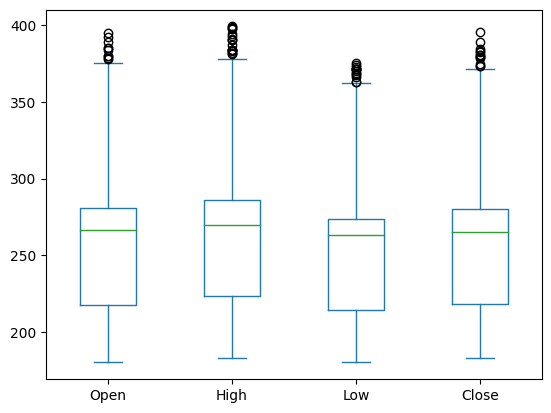

In [542]:
Data[['Open','High','Low','Close']].plot(kind='box')

<Axes: >

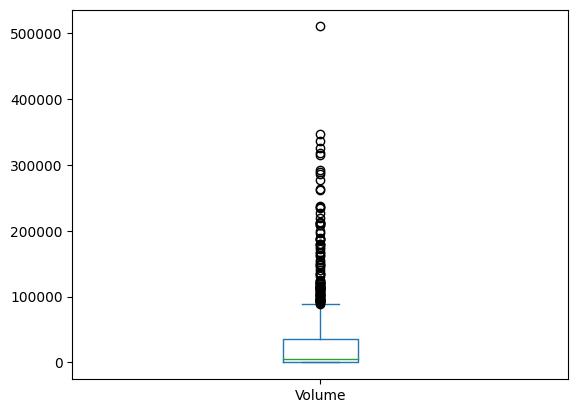

In [543]:
Data[['Volume']].plot(kind='box')

In [544]:
Data.describe()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
count,1067,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2022-06-20 00:00:00,262.221192,266.499364,257.698513,261.172421,28682.998126,15.679475,6.402999,2021.977507,261.236223,261.598950,262.006970,262.845542
min,2021-01-03 00:00:00,180.200000,183.000000,180.200000,183.000000,0.000000,1.000000,1.000000,2021.000000,183.000000,183.000000,183.000000,183.000000
25%,2021-09-26 12:00:00,217.800000,223.800000,214.550000,218.350000,0.000000,8.000000,3.000000,2021.000000,218.700000,219.800000,230.500000,243.050000
50%,2022-06-20 00:00:00,266.500000,269.854286,263.500000,265.350000,6038.000000,16.000000,6.000000,2022.000000,265.350000,265.362857,265.362857,265.418571
75%,2023-03-13 12:00:00,280.725000,285.850000,273.850000,279.900000,35568.500000,23.000000,9.000000,2023.000000,279.900000,279.900000,279.900000,279.900000
max,2023-12-05 00:00:00,394.800000,399.000000,375.000000,395.700000,510410.000000,31.000000,12.000000,2023.000000,395.700000,395.700000,395.700000,395.700000
std,NaN,47.650910,49.585011,45.232791,46.863981,52300.893272,8.805506,3.377543,0.811191,46.821219,46.576296,46.256021,45.565800


In [545]:
close_prices = Data['Close']
Q1 = close_prices.quantile(0.25)
Q3 = close_prices.quantile(0.75)
print(Q1)
print(Q3)

218.35
279.9


In [546]:
IQR = Q3 - Q1
print(IQR)

61.54999999999998


In [547]:
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
print(lower_bound)
print(upper_bound)

33.700000000000045
464.54999999999995


In [548]:
outliers = Data[(close_prices < lower_bound) | (close_prices > upper_bound)]
print(outliers)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, day, month, year, 1_day, 1_week, 15_days, 1_month]
Index: []


No outliers

In [549]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1067 non-null   datetime64[ns]
 1   Open     1067 non-null   float64       
 2   High     1067 non-null   float64       
 3   Low      1067 non-null   float64       
 4   Close    1067 non-null   float64       
 5   Volume   1067 non-null   float64       
 6   day      1067 non-null   int32         
 7   month    1067 non-null   int32         
 8   year     1067 non-null   int32         
 9   1_day    1067 non-null   float64       
 10  1_week   1067 non-null   float64       
 11  15_days  1067 non-null   float64       
 12  1_month  1067 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3)
memory usage: 104.2 KB


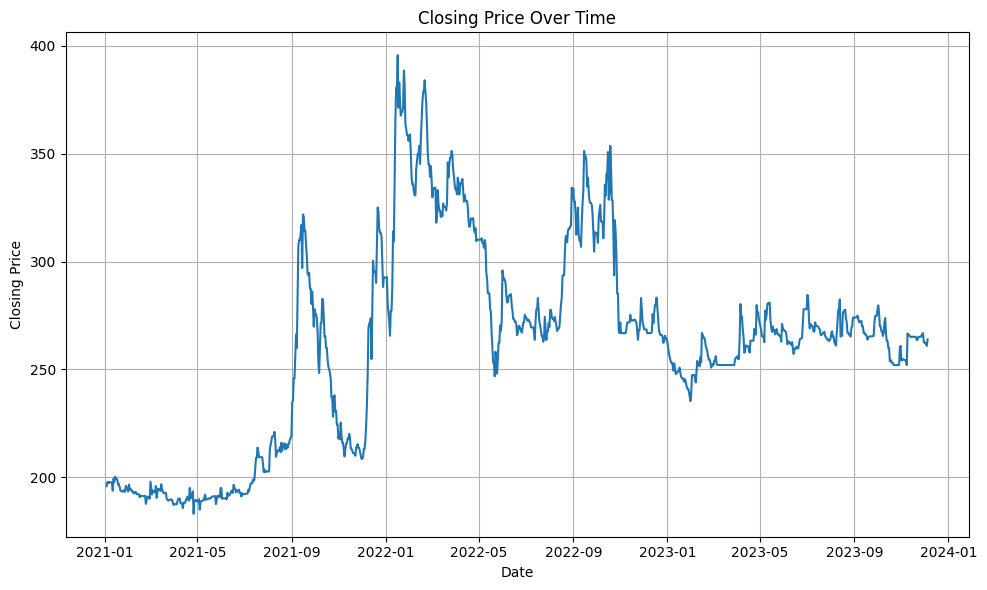

In [550]:
plt.figure(figsize=(10,6))
plt.plot(Data['Date'], Data['Close']) 
plt.title('Closing Price Over Time')  
plt.xlabel('Date')  
plt.ylabel('Closing Price')  
plt.grid(True)  
plt.tight_layout() 
plt.show()

# Add SMA, RSI, MACD

In [551]:
Data.loc[:, 'SMA_7'] = Data['Close'].rolling(window=7).mean()
Data.loc[:, 'SMA_7'].fillna(Data['Close'].iloc[0], inplace=True)

In [552]:
Data['MACD'] = Data['Close'].ewm(span=26, adjust=False).mean() - Data['Close'].ewm(span=12, adjust=False).mean()
Data['Signal_Line'] = Data['MACD'].ewm(span=9, adjust=False).mean()
Data['ema'] = Data['Close'].ewm(span=5, adjust=False).mean()

In [553]:
Data.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,195.1,197.0,194.5,195.8,6809.0,3,1,2021,197.7,197.4,196.5,194.8,195.8,0.000000,0.000000,195.800000
1,2021-01-04,197.8,199.0,197.0,197.7,4473.0,4,1,2021,197.7,193.7,196.8,194.0,195.8,-0.151567,-0.030313,196.433333
2,2021-01-05,195.0,199.0,195.0,197.7,2974.0,5,1,2021,197.3,199.3,195.3,194.3,195.8,-0.268589,-0.077968,196.855556
3,2021-01-06,202.5,202.5,196.5,197.3,7801.0,6,1,2021,197.8,197.8,193.8,193.4,195.8,-0.325303,-0.127435,197.003704
4,2021-01-07,200.0,200.0,197.5,197.8,5833.0,7,1,2021,197.6,200.2,193.5,193.4,195.8,-0.405916,-0.183131,197.269136


In [554]:
Dataset = Data.copy()

# Apply Random Forest

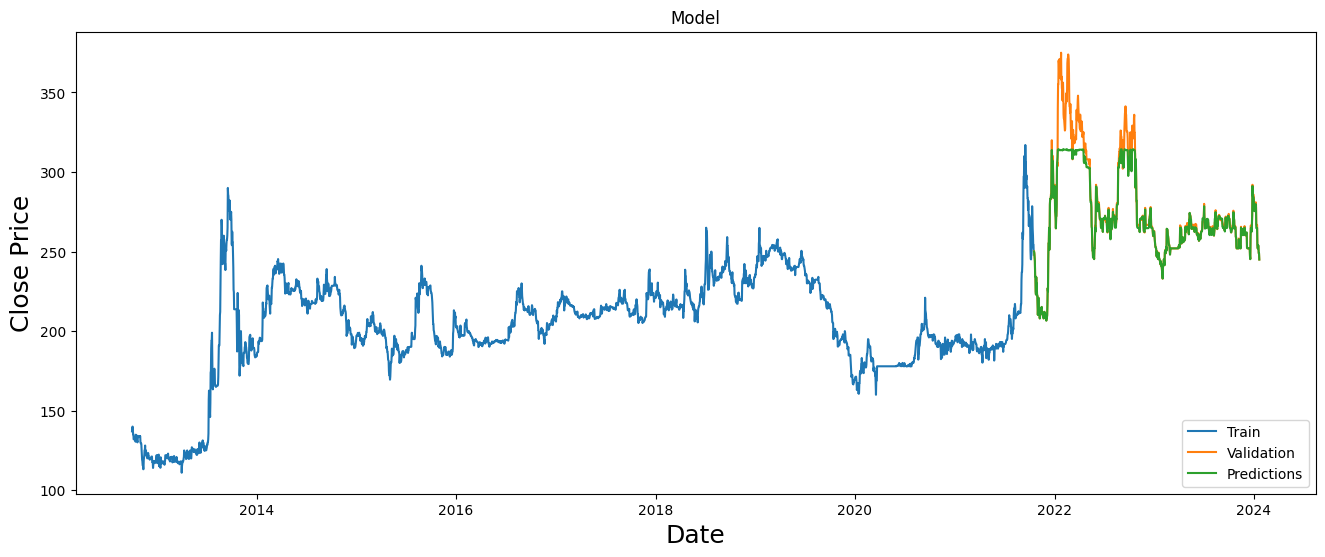

In [435]:
# RfDF1 = Dataset.copy()
# n_estimators = 70
# random_state = 15
# features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
# target = 'Low'
# dff = run_random_forest2(RfDF1, n_estimators, random_state,features, target)

In [436]:
# dff = pd.DataFrame(dff, columns=['Column1'])
# dff.to_csv('faww.csv', index=False)

1 day ahead prediction

Mean Squared Error: 11.845
Root Mean Squared Error: 3.442
R-squared Score: 0.744


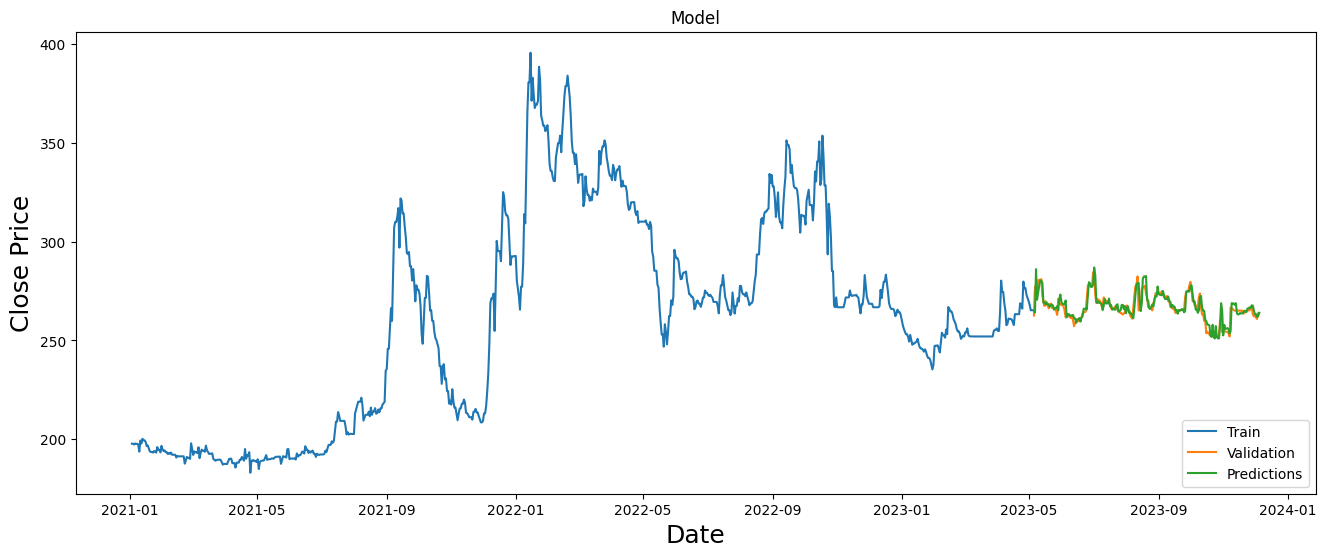

(11.844991616131871, 3.4416553598714485, 0.744399890787745)

In [555]:
RfDF1 = Dataset.copy()
n_estimators = 70
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)

1 week ahead prediction 

Mean Squared Error: 68.164
Root Mean Squared Error: 8.256
R-squared Score: -0.551


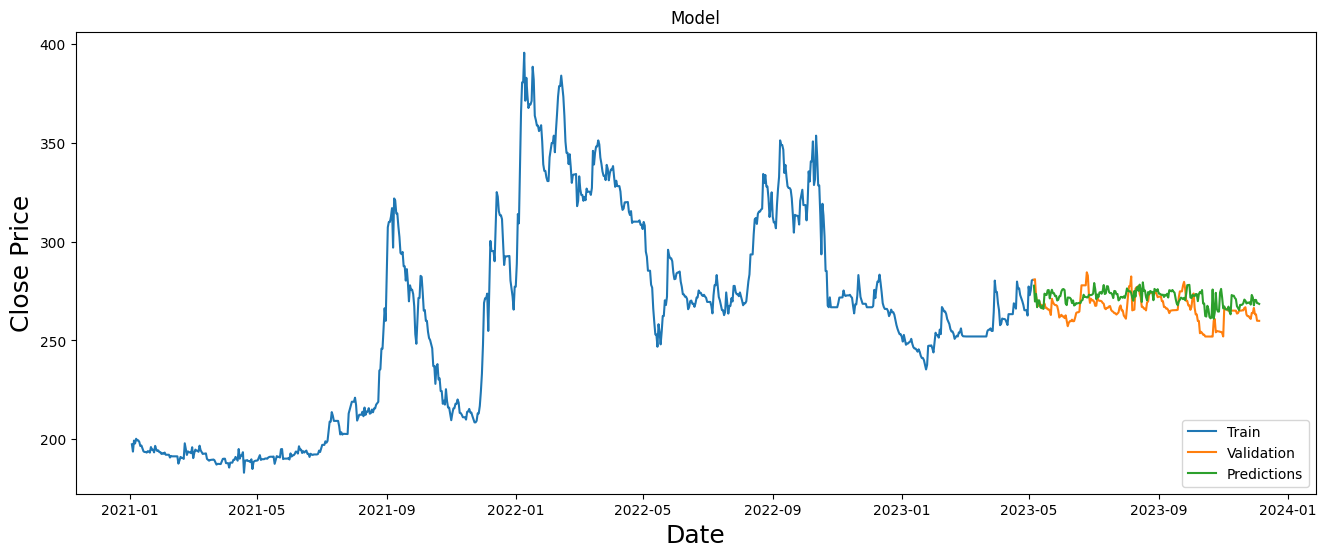

(68.1639705165044, 8.25614743790979, -0.5510409966088212)

In [556]:
RfDF7 = Dataset.copy()
n_estimators = 120
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

15 days ahead prediction 

Mean Squared Error: 198.439
Root Mean Squared Error: 14.087
R-squared Score: -3.139


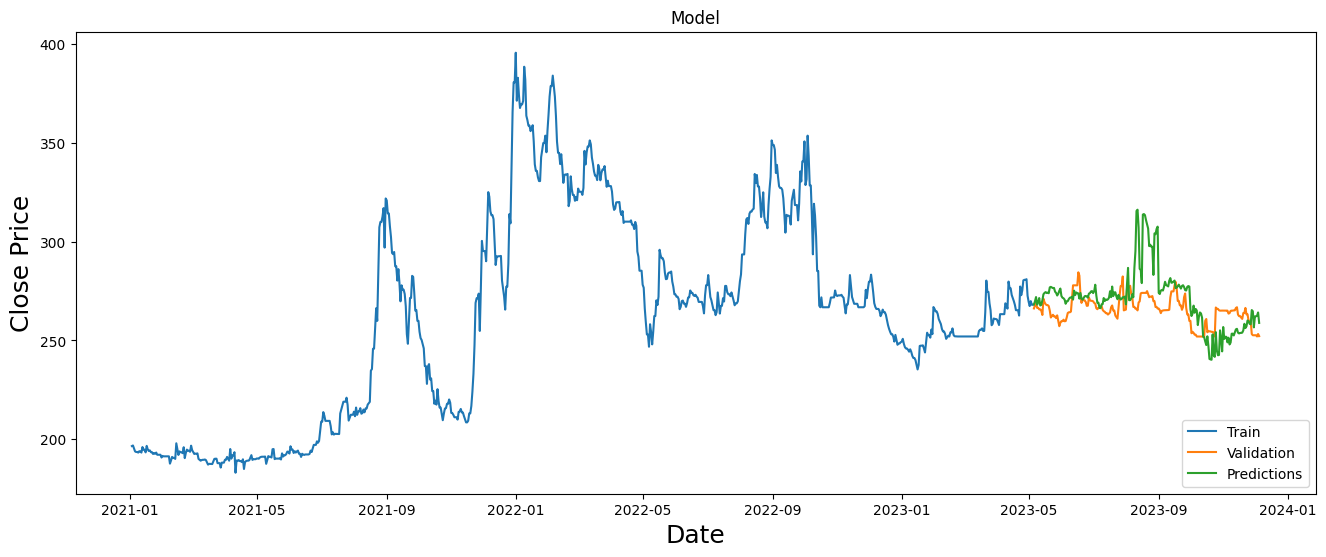

(198.4389092807012, 14.086834608268147, -3.139132345256459)

In [561]:
RfDF15 = Dataset.copy()
n_estimators = 120
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

# Apply LSTM

1 Day

In [562]:
LDF1 = Dataset.copy()
LDF1.head()


,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,195.1,197.0,194.5,195.8,6809.0,3,1,2021,197.7,197.4,196.5,194.8,195.8,0.000000,0.000000,195.800000
1,2021-01-04,197.8,199.0,197.0,197.7,4473.0,4,1,2021,197.7,193.7,196.8,194.0,195.8,-0.151567,-0.030313,196.433333
2,2021-01-05,195.0,199.0,195.0,197.7,2974.0,5,1,2021,197.3,199.3,195.3,194.3,195.8,-0.268589,-0.077968,196.855556
3,2021-01-06,202.5,202.5,196.5,197.3,7801.0,6,1,2021,197.8,197.8,193.8,193.4,195.8,-0.325303,-0.127435,197.003704
4,2021-01-07,200.0,200.0,197.5,197.8,5833.0,7,1,2021,197.6,200.2,193.5,193.4,195.8,-0.405916,-0.183131,197.269136


In [567]:
epochs = 80
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_day
80
40
Epoch 1/80
22/22 - 3s - loss: 0.0459 - 3s/epoch - 122ms/step
Epoch 2/80
22/22 - 0s - loss: 0.0055 - 185ms/epoch - 8ms/step
Epoch 3/80
22/22 - 0s - loss: 0.0033 - 201ms/epoch - 9ms/step
Epoch 4/80
22/22 - 0s - loss: 0.0030 - 185ms/epoch - 8ms/step
Epoch 5/80
22/22 - 0s - loss: 0.0030 - 185ms/epoch - 8ms/step
Epoch 6/80
22/22 - 0s - loss: 0.0028 - 185ms/epoch - 8ms/step
Epoch 7/80
22/22 - 0s - loss: 0.0025 - 332ms/epoch - 15ms/step
Epoch 8/80
22/22 - 0s - loss: 0.0024 - 185ms/epoch - 8ms/step
Epoch 9/80
22/22 - 0s - loss: 0.0023 - 270ms/epoch - 12ms/step
Epoch 10/80
22/22 - 0s - loss: 0.0021 - 154ms/epoch - 7ms/step
Epoch 11/80
22/22 - 0s - loss: 0.0021 - 163ms/epoch - 7ms/step
Epoch 12/80
22/22 - 0s - loss: 0.0019 - 169ms/epoch - 8ms/step
Epoch 13/80
22/22 - 0s - loss: 0.0020 - 169ms/epoch - 8ms/step
Epoch 14/80
22/22 - 0s - loss: 0.0019 - 163ms/epoch - 7ms/step
Epoch 15/80
22/22 - 0s - loss: 0.0018 - 169ms/e

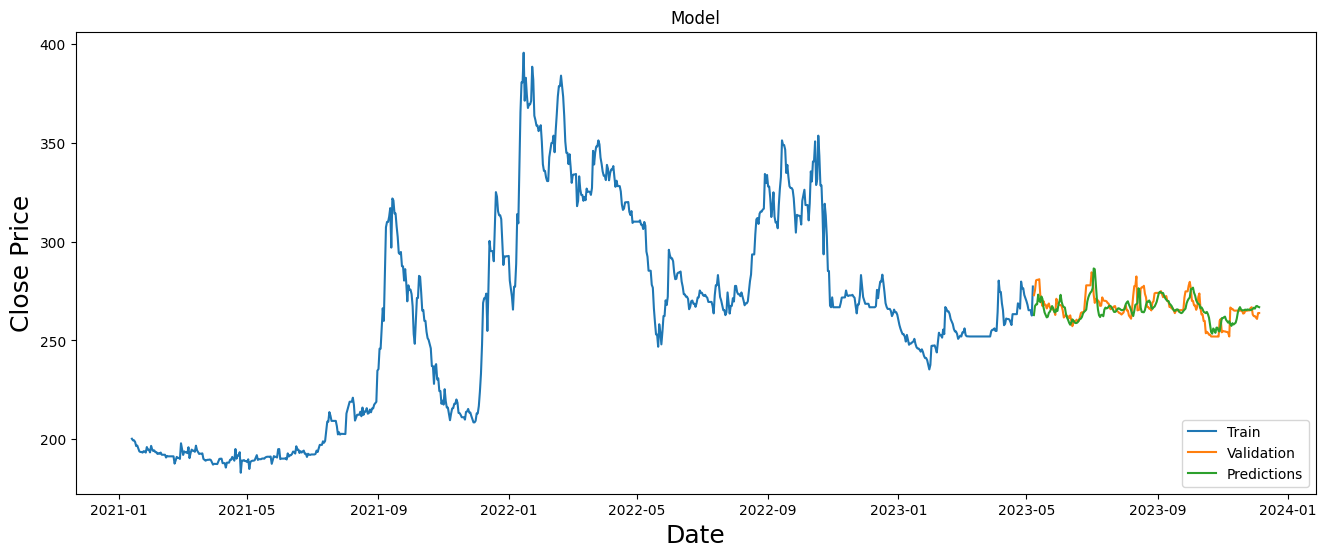

In [568]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

1 week

In [569]:
LDF7 = Dataset.copy()
LDF7.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,195.1,197.0,194.5,195.8,6809.0,3,1,2021,197.7,197.4,196.5,194.8,195.8,0.000000,0.000000,195.800000
1,2021-01-04,197.8,199.0,197.0,197.7,4473.0,4,1,2021,197.7,193.7,196.8,194.0,195.8,-0.151567,-0.030313,196.433333
2,2021-01-05,195.0,199.0,195.0,197.7,2974.0,5,1,2021,197.3,199.3,195.3,194.3,195.8,-0.268589,-0.077968,196.855556
3,2021-01-06,202.5,202.5,196.5,197.3,7801.0,6,1,2021,197.8,197.8,193.8,193.4,195.8,-0.325303,-0.127435,197.003704
4,2021-01-07,200.0,200.0,197.5,197.8,5833.0,7,1,2021,197.6,200.2,193.5,193.4,195.8,-0.405916,-0.183131,197.269136


In [575]:
epochs = 120
batch_size = 30
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_week
120
30
Epoch 1/120
29/29 - 3s - loss: 0.1005 - 3s/epoch - 87ms/step
Epoch 2/120
29/29 - 0s - loss: 0.0153 - 216ms/epoch - 7ms/step
Epoch 3/120
29/29 - 0s - loss: 0.0116 - 207ms/epoch - 7ms/step
Epoch 4/120
29/29 - 0s - loss: 0.0108 - 232ms/epoch - 8ms/step
Epoch 5/120
29/29 - 0s - loss: 0.0104 - 201ms/epoch - 7ms/step
Epoch 6/120
29/29 - 0s - loss: 0.0099 - 216ms/epoch - 7ms/step
Epoch 7/120
29/29 - 0s - loss: 0.0095 - 216ms/epoch - 7ms/step
Epoch 8/120
29/29 - 0s - loss: 0.0090 - 201ms/epoch - 7ms/step
Epoch 9/120
29/29 - 0s - loss: 0.0088 - 223ms/epoch - 8ms/step
Epoch 10/120
29/29 - 0s - loss: 0.0081 - 216ms/epoch - 7ms/step
Epoch 11/120
29/29 - 0s - loss: 0.0078 - 216ms/epoch - 7ms/step
Epoch 12/120
29/29 - 0s - loss: 0.0074 - 216ms/epoch - 7ms/step
Epoch 13/120
29/29 - 0s - loss: 0.0071 - 216ms/epoch - 7ms/step
Epoch 14/120
29/29 - 0s - loss: 0.0068 - 216ms/epoch - 7ms/step
Epoch 15/120
29/29 - 0s - loss: 0.

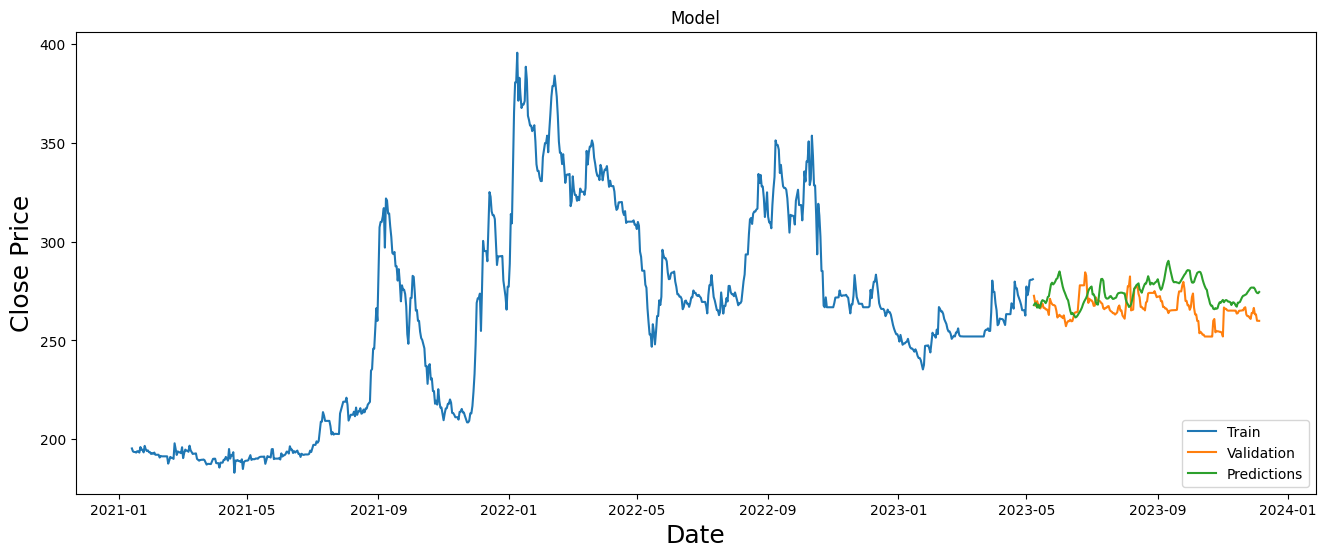

In [576]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

15 days

In [581]:
LDF15 = Dataset.copy()
epochs = 100
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
15_days
100
40
Epoch 1/100
22/22 - 2s - loss: 0.0706 - 2s/epoch - 110ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0217 - 169ms/epoch - 8ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0171 - 169ms/epoch - 8ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0164 - 178ms/epoch - 8ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0154 - 185ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0150 - 169ms/epoch - 8ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0146 - 169ms/epoch - 8ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0142 - 178ms/epoch - 8ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0138 - 169ms/epoch - 8ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0136 - 185ms/epoch - 8ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0131 - 185ms/epoch - 8ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0132 - 169ms/epoch - 8ms/step
Epoch 13/100
22/22 - 0s - loss: 0.0128 - 178ms/epoch - 8ms/step
Epoch 14/100
22/22 - 0s - loss: 0.0123 - 185ms/epoch - 8ms/step
Epoch 15/100
22/22 - 0s - loss: 

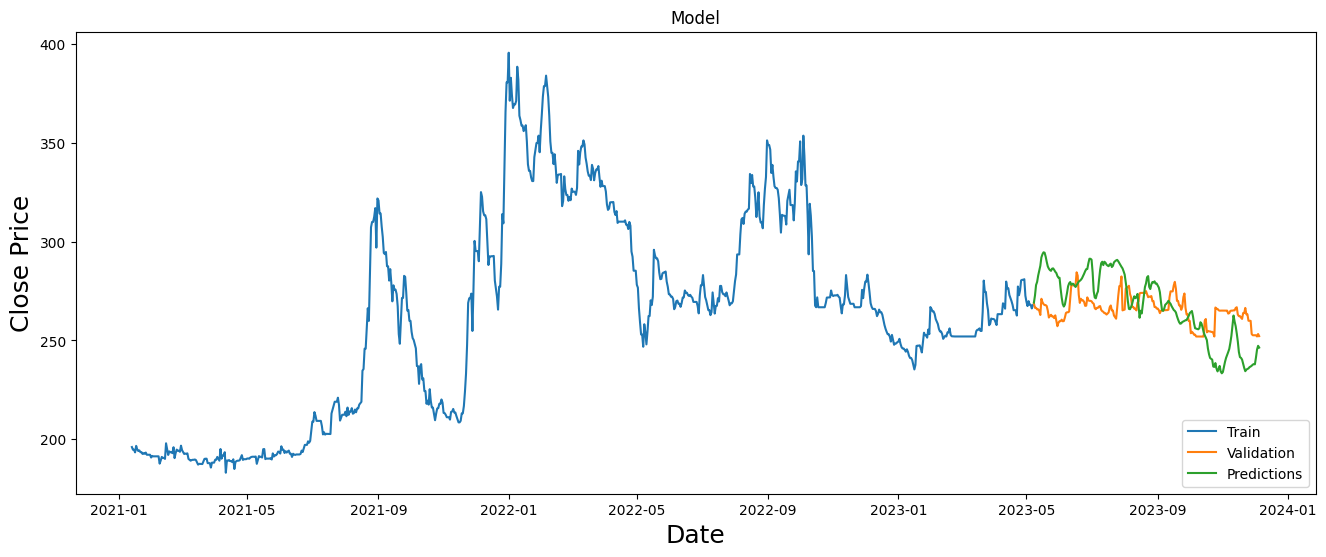

In [582]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# Apply GRU

1 day

In [584]:
GDF1 = Dataset.copy()
epochs = 100
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_day
100
30
Epoch 1/100
29/29 [==============================] - 7s 16ms/step - loss: 0.0277
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0041
Epoch 3/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0032
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0029
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 6/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 7/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0024
Epoch 8/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0022
Epoch 9/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0021
Epoch 10/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0019
Epoch 11/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 12/100
29/29 [=======

7/7 [==============================] - 1s 6ms/step
Mean Squared Error (MSE): 25.616
Root Mean Squared Error (RMSE): 5.061
R-squared Score (R2): 0.445


1 week

In [600]:
GDF7 = Dataset.copy()
epochs = 80
batch_size = 40
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_week
80
40
Epoch 1/80
22/22 [==============================] - 7s 18ms/step - loss: 0.0456
Epoch 2/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0116
Epoch 3/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0095
Epoch 4/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0089
Epoch 5/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0088
Epoch 6/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0087
Epoch 7/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0085
Epoch 8/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0082
Epoch 9/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0081
Epoch 10/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0079
Epoch 11/80
22/22 [==============================] - 0s 17ms/step - loss: 0.0078
Epoch 12/80
22/22 [===================

15 days

In [598]:
GDF15 = Dataset.copy()
epochs = 100
batch_size = 40
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
15_days
100
40
Epoch 1/100
22/22 [==============================] - 7s 17ms/step - loss: 0.0540
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0193
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0161
Epoch 4/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0159
Epoch 5/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0156
Epoch 6/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0156
Epoch 7/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0152
Epoch 8/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0154
Epoch 9/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0150
Epoch 10/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0148
Epoch 11/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0147
Epoch 12/100
22/22 [=====

7/7 [==============================] - 1s 5ms/step
Mean Squared Error (MSE): 152.701
Root Mean Squared Error (RMSE): 12.357
R-squared Score (R2): -2.157


# Apply XGboost

1 day

In [603]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,195.1,197.0,194.5,195.8,6809.0,3,1,2021,197.7,197.4,196.5,194.8,195.8,0.000000,0.000000,195.800000
1,2021-01-04,197.8,199.0,197.0,197.7,4473.0,4,1,2021,197.7,193.7,196.8,194.0,195.8,-0.151567,-0.030313,196.433333
2,2021-01-05,195.0,199.0,195.0,197.7,2974.0,5,1,2021,197.3,199.3,195.3,194.3,195.8,-0.268589,-0.077968,196.855556
3,2021-01-06,202.5,202.5,196.5,197.3,7801.0,6,1,2021,197.8,197.8,193.8,193.4,195.8,-0.325303,-0.127435,197.003704
4,2021-01-07,200.0,200.0,197.5,197.8,5833.0,7,1,2021,197.6,200.2,193.5,193.4,195.8,-0.405916,-0.183131,197.269136


Mean Squared Error: 30.278971588347925
Root Mean Squared Error: 5.502633150442425
R-squared: 0.34661765110274845


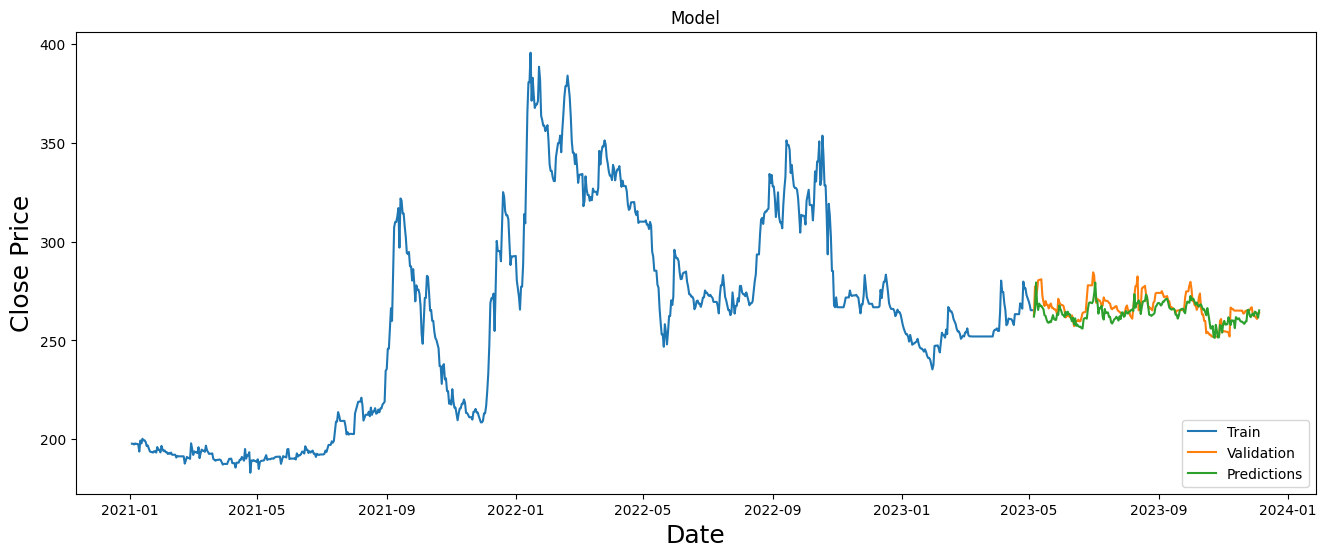

In [604]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

1 week

Mean Squared Error: 59.95613734732766
Root Mean Squared Error: 7.743134852714865
R-squared: -0.36427538359869915


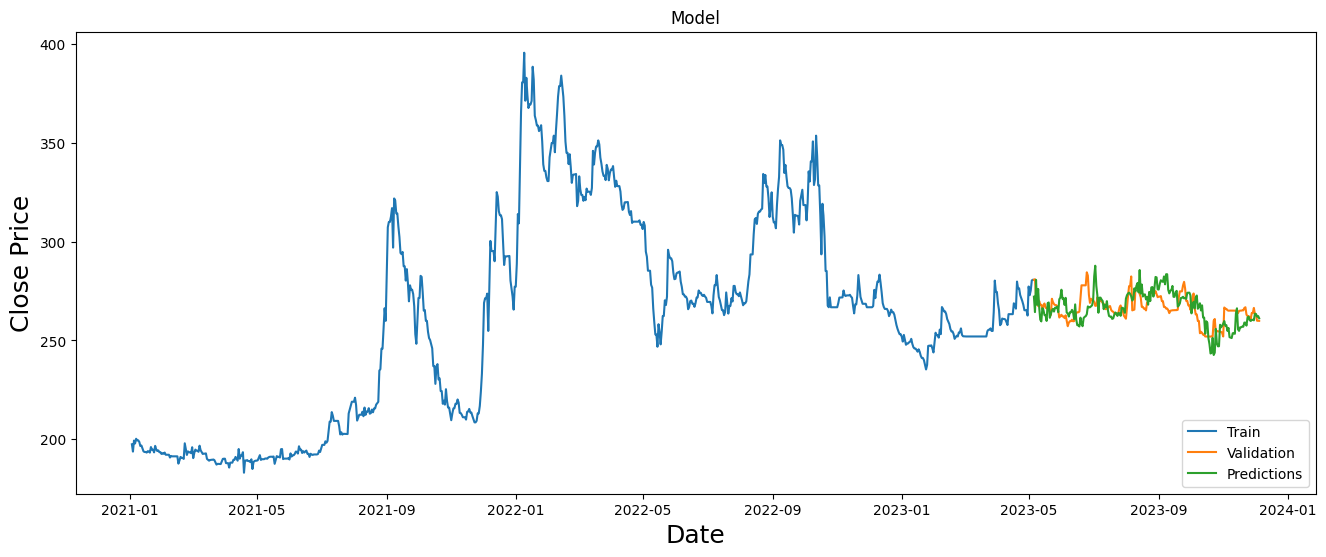

In [605]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

15 days

Mean Squared Error: 173.24136341240217
Root Mean Squared Error: 13.162118500165624
R-squared: -2.613550051428043


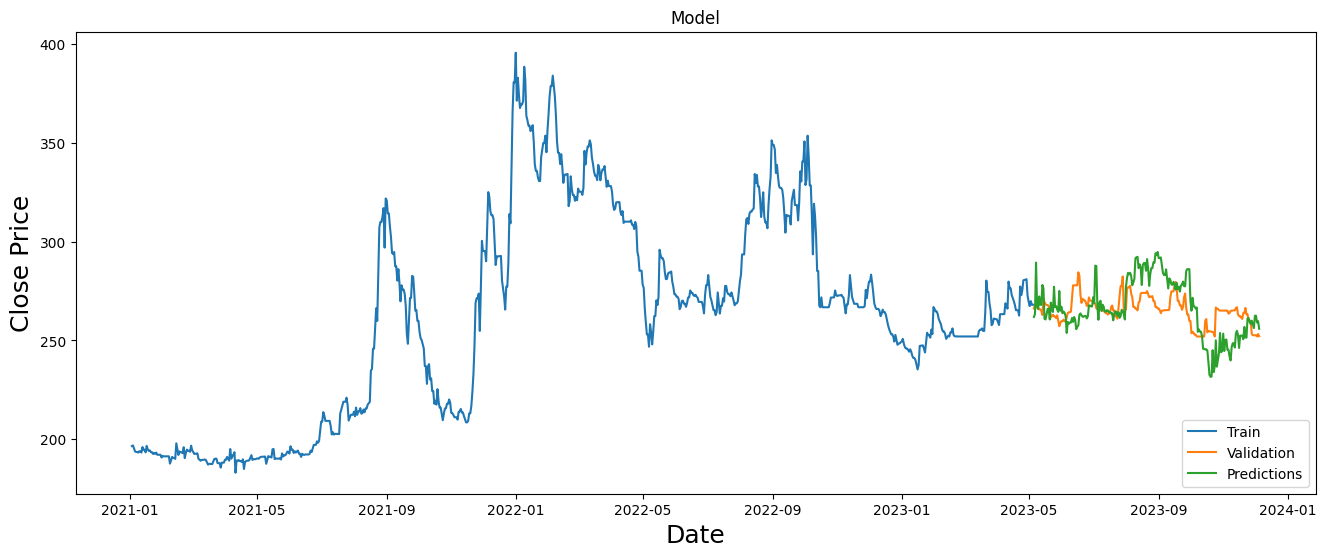

In [606]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

1 month

#  EMA

# Apply Random Forest

In [607]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,195.1,197.0,194.5,195.8,6809.0,3,1,2021,197.7,197.4,196.5,194.8,195.8,0.000000,0.000000,195.800000
1,2021-01-04,197.8,199.0,197.0,197.7,4473.0,4,1,2021,197.7,193.7,196.8,194.0,195.8,-0.151567,-0.030313,196.433333
2,2021-01-05,195.0,199.0,195.0,197.7,2974.0,5,1,2021,197.3,199.3,195.3,194.3,195.8,-0.268589,-0.077968,196.855556
3,2021-01-06,202.5,202.5,196.5,197.3,7801.0,6,1,2021,197.8,197.8,193.8,193.4,195.8,-0.325303,-0.127435,197.003704
4,2021-01-07,200.0,200.0,197.5,197.8,5833.0,7,1,2021,197.6,200.2,193.5,193.4,195.8,-0.405916,-0.183131,197.269136


Mean Squared Error: 11.058
Root Mean Squared Error: 3.325
R-squared Score: 0.761


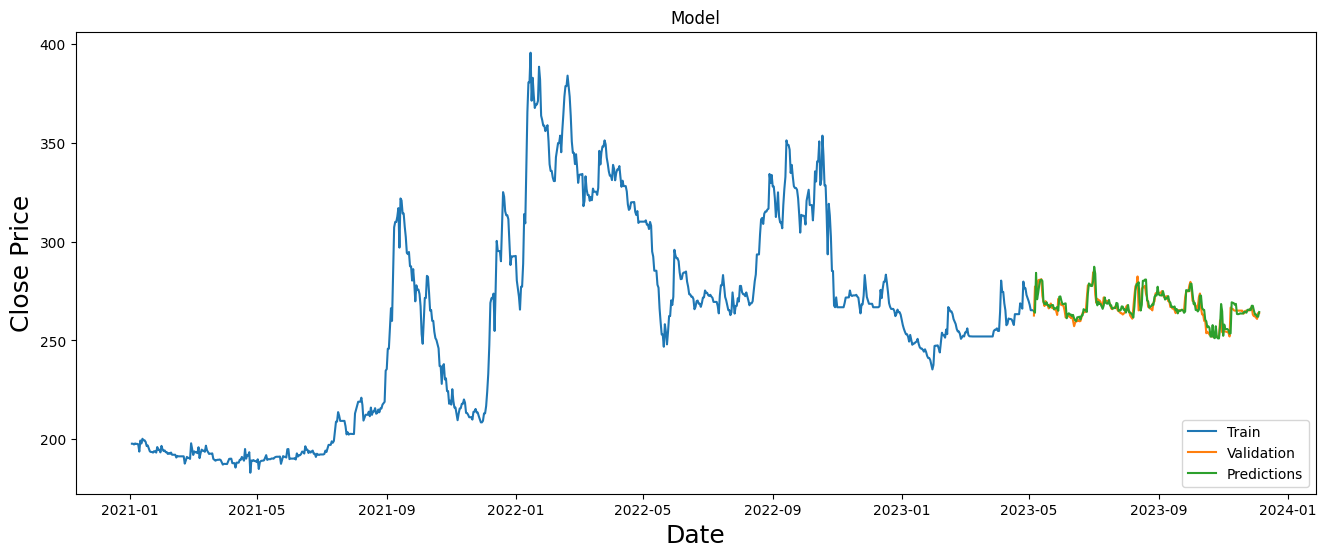

(11.058328403198102, 3.3254065019480104, 0.7613750993531351)

In [609]:
RfDF1 = Dataset.copy()
n_estimators = 70
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)


Mean Squared Error: 67.801
Root Mean Squared Error: 8.234
R-squared Score: -0.543


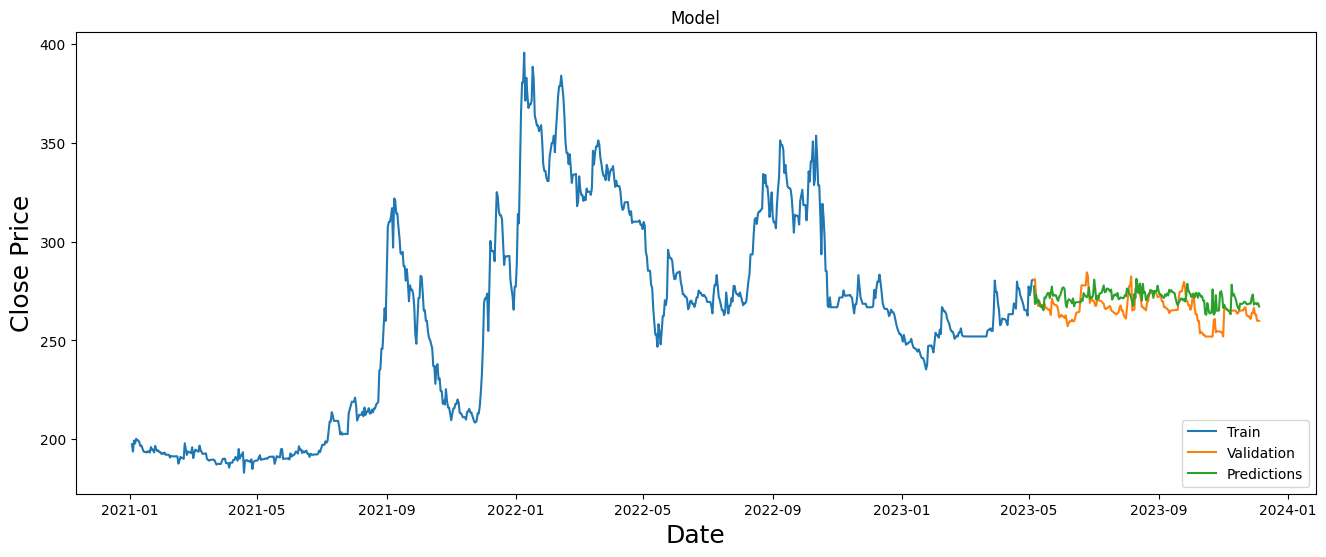

(67.80095921362496, 8.234133786478392, -0.5427808349907115)

In [614]:
RfDF7 = Dataset.copy()
n_estimators = 150
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

Mean Squared Error: 207.149
Root Mean Squared Error: 14.393
R-squared Score: -3.321


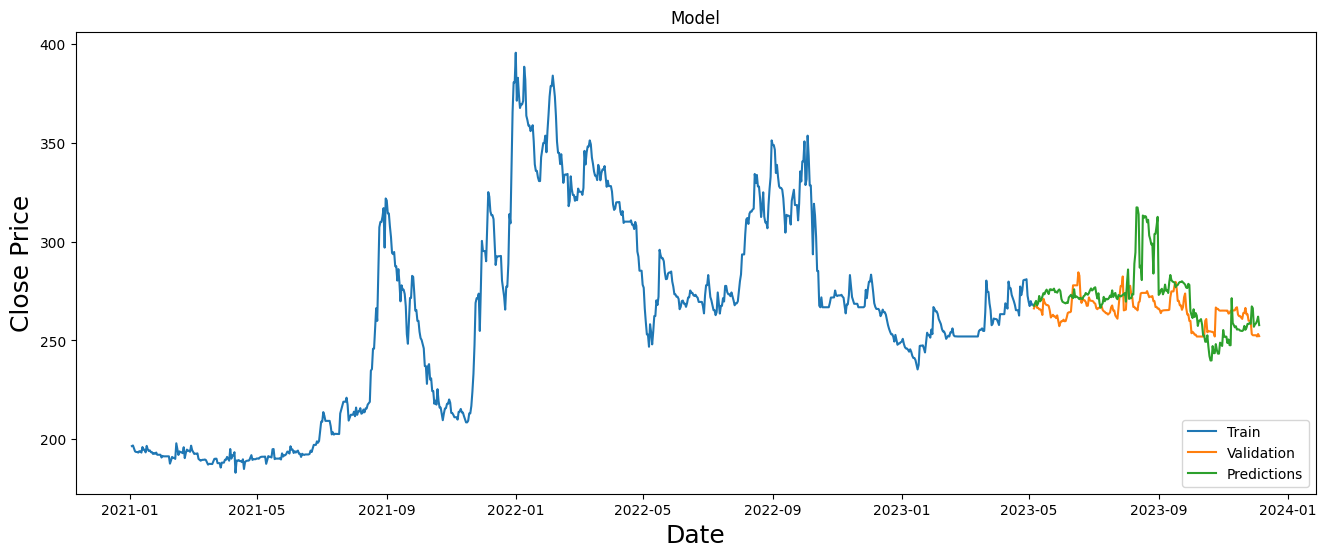

(207.1488410501315, 14.392666224509325, -3.320808209342313)

In [618]:
RfDF15 = Dataset.copy()
n_estimators = 150
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

# Apply LSTM

In [622]:
LDF1 = Dataset.copy()
epochs = 80
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_day
80
40
Epoch 1/80
22/22 - 3s - loss: 0.1216 - 3s/epoch - 120ms/step
Epoch 2/80
22/22 - 0s - loss: 0.0146 - 201ms/epoch - 9ms/step
Epoch 3/80
22/22 - 0s - loss: 0.0066 - 185ms/epoch - 8ms/step
Epoch 4/80
22/22 - 0s - loss: 0.0056 - 201ms/epoch - 9ms/step
Epoch 5/80
22/22 - 0s - loss: 0.0047 - 201ms/epoch - 9ms/step
Epoch 6/80
22/22 - 0s - loss: 0.0042 - 178ms/epoch - 8ms/step
Epoch 7/80
22/22 - 0s - loss: 0.0038 - 201ms/epoch - 9ms/step
Epoch 8/80
22/22 - 0s - loss: 0.0035 - 185ms/epoch - 8ms/step
Epoch 9/80
22/22 - 0s - loss: 0.0032 - 185ms/epoch - 8ms/step
Epoch 10/80
22/22 - 0s - loss: 0.0029 - 185ms/epoch - 8ms/step
Epoch 11/80
22/22 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 12/80
22/22 - 0s - loss: 0.0024 - 201ms/epoch - 9ms/step
Epoch 13/80
22/22 - 0s - loss: 0.0023 - 185ms/epoch - 8ms/step
Epoch 14/80
22/22 - 0s - loss: 0.0021 - 201ms/epoch - 9ms/step
Epoch 15/80
22/22 - 0s - loss: 0.0023 - 18

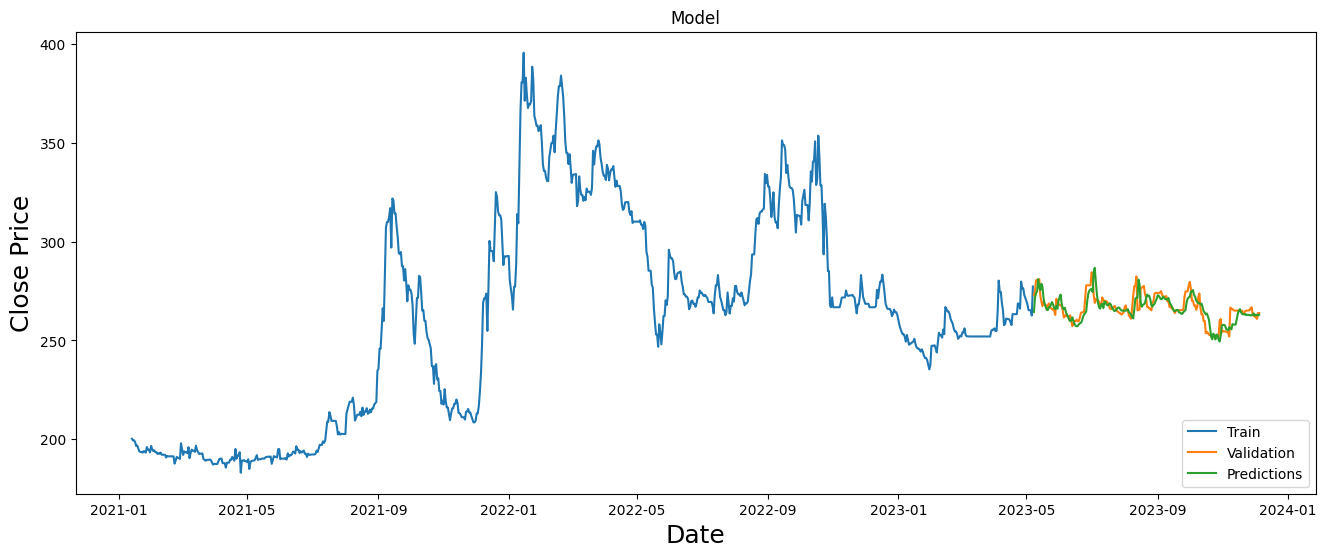

In [623]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [624]:
LDF7 = Dataset.copy()
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_week
120
40
Epoch 1/120
22/22 - 3s - loss: 0.1311 - 3s/epoch - 126ms/step
Epoch 2/120
22/22 - 0s - loss: 0.0234 - 201ms/epoch - 9ms/step
Epoch 3/120
22/22 - 0s - loss: 0.0143 - 201ms/epoch - 9ms/step
Epoch 4/120
22/22 - 0s - loss: 0.0112 - 185ms/epoch - 8ms/step
Epoch 5/120
22/22 - 0s - loss: 0.0102 - 185ms/epoch - 8ms/step
Epoch 6/120
22/22 - 0s - loss: 0.0097 - 201ms/epoch - 9ms/step
Epoch 7/120
22/22 - 0s - loss: 0.0091 - 194ms/epoch - 9ms/step
Epoch 8/120
22/22 - 0s - loss: 0.0088 - 178ms/epoch - 8ms/step
Epoch 9/120
22/22 - 0s - loss: 0.0084 - 169ms/epoch - 8ms/step
Epoch 10/120
22/22 - 0s - loss: 0.0086 - 185ms/epoch - 8ms/step
Epoch 11/120
22/22 - 0s - loss: 0.0077 - 201ms/epoch - 9ms/step
Epoch 12/120
22/22 - 0s - loss: 0.0074 - 185ms/epoch - 8ms/step
Epoch 13/120
22/22 - 0s - loss: 0.0072 - 216ms/epoch - 10ms/step
Epoch 14/120
22/22 - 0s - loss: 0.0070 - 201ms/epoch - 9ms/step
Epoch 15/120
22/22 - 0s -

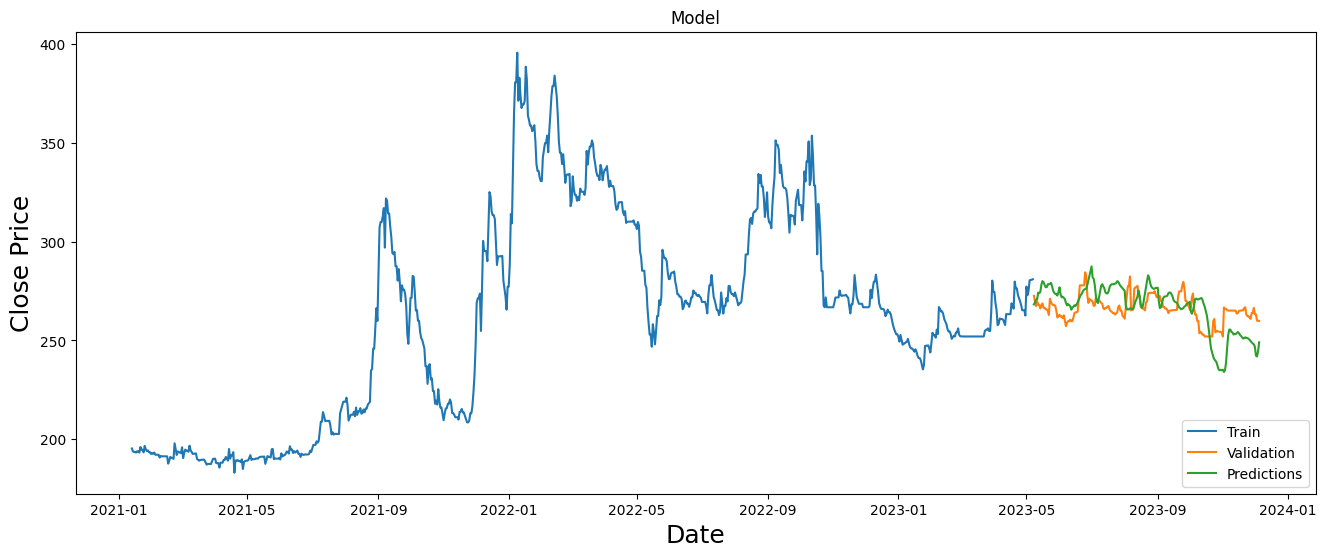

In [625]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [627]:
LDF15 = Dataset.copy()
epochs = 100
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
15_days
100
40
Epoch 1/100
22/22 - 3s - loss: 0.0673 - 3s/epoch - 119ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0196 - 201ms/epoch - 9ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0174 - 185ms/epoch - 8ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0162 - 185ms/epoch - 8ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0158 - 185ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0156 - 178ms/epoch - 8ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0148 - 185ms/epoch - 8ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0142 - 185ms/epoch - 8ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0134 - 169ms/epoch - 8ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0131 - 185ms/epoch - 8ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0124 - 185ms/epoch - 8ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0119 - 185ms/epoch - 8ms/step
Epoch 13/100
22/22 - 0s - loss: 0.0119 - 178ms/epoch - 8ms/step
Epoch 14/100
22/22 - 0s - loss: 0.0110 - 185ms/epoch - 8ms/step
Epoch 15/100
22/22 - 0s -

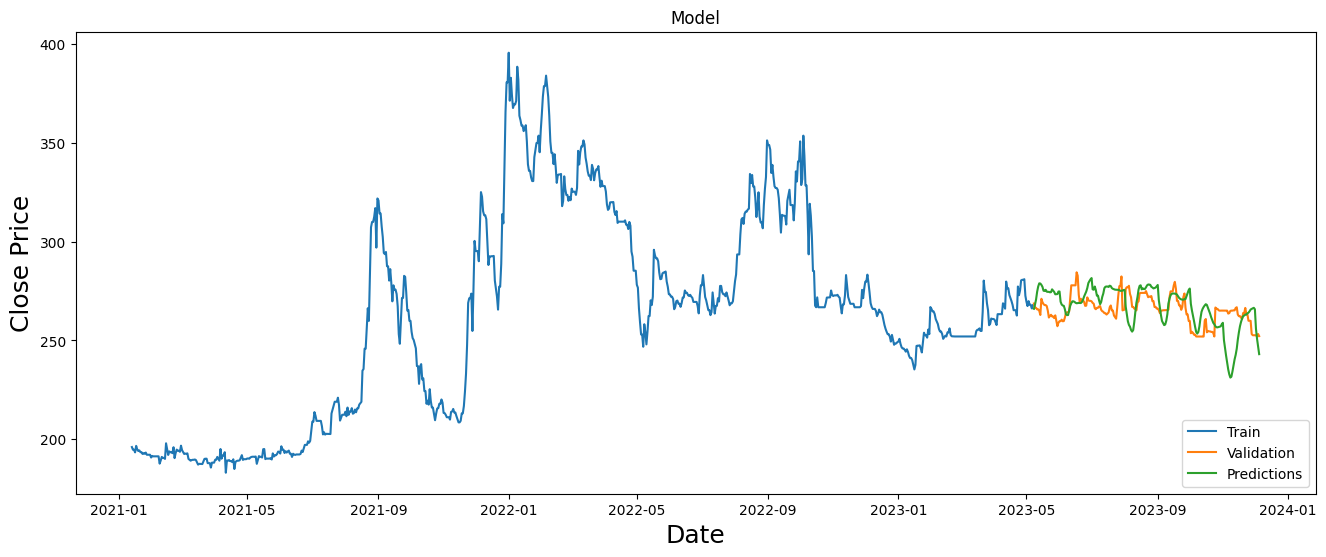

In [628]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# GRU

In [629]:
GDF1 = Dataset.copy()
epochs = 90
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_day
90
30
Epoch 1/90
29/29 [==============================] - 7s 16ms/step - loss: 0.0165
Epoch 2/90
29/29 [==============================] - 0s 16ms/step - loss: 0.0032
Epoch 3/90
29/29 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 4/90
29/29 [==============================] - 0s 16ms/step - loss: 0.0024
Epoch 5/90
29/29 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 6/90
29/29 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 7/90
29/29 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 8/90
29/29 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 9/90
29/29 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 10/90
29/29 [==============================] - 0s 17ms/step - loss: 0.0017
Epoch 11/90
29/29 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 12/90
29/29 [=============

In [635]:
GDF7 = Dataset.copy()
epochs = 80
batch_size = 40
Features =  ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_week
80
40
Epoch 1/80
22/22 [==============================] - 7s 18ms/step - loss: 0.0837
Epoch 2/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0147
Epoch 3/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0100
Epoch 4/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0092
Epoch 5/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0091
Epoch 6/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0089
Epoch 7/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0087
Epoch 8/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0086
Epoch 9/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0084
Epoch 10/80
22/22 [==============================] - 0s 19ms/step - loss: 0.0083
Epoch 11/80
22/22 [==============================] - 0s 18ms/step - loss: 0.0083
Epoch 12/80
22/22 [============

In [647]:
GDF15 = Dataset.copy()
epochs = 100
batch_size = 40
Features =  ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
15_days
100
40
Epoch 1/100
22/22 [==============================] - 7s 18ms/step - loss: 0.0376
Epoch 2/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0165
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0157
Epoch 4/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0155
Epoch 5/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0157
Epoch 6/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0156
Epoch 7/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0151
Epoch 8/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0149
Epoch 9/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0150
Epoch 10/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0143
Epoch 11/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0142
Epoch 12/100
22/22

Epoch 100/100
7/7 [==============================] - 1s 6ms/step
Mean Squared Error (MSE): 188.426
Root Mean Squared Error (RMSE): 13.727
R-squared Score (R2): -2.896


# XGBoost

Mean Squared Error: 14.82698226321509
Root Mean Squared Error: 3.85058206810543
R-squared: 0.6800522610244326


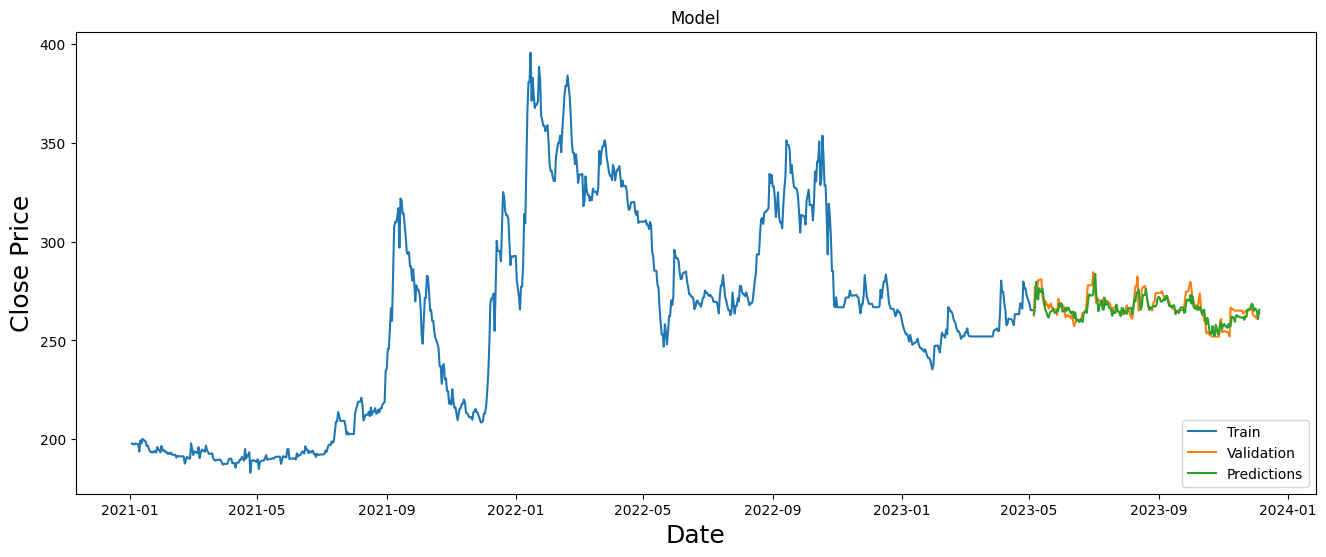

In [649]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

Mean Squared Error: 57.3906245000434
Root Mean Squared Error: 7.5756600042533195
R-squared: -0.30589827361944644


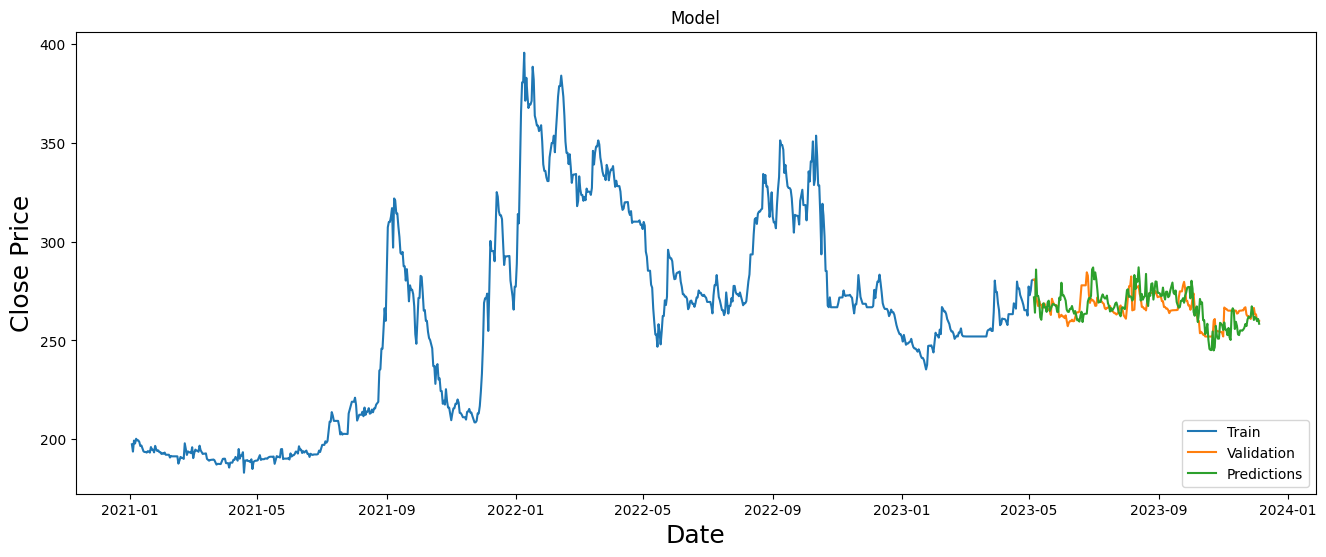

In [650]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

Mean Squared Error: 188.09855147732043
Root Mean Squared Error: 13.714902532549052
R-squared: -2.923448286113825


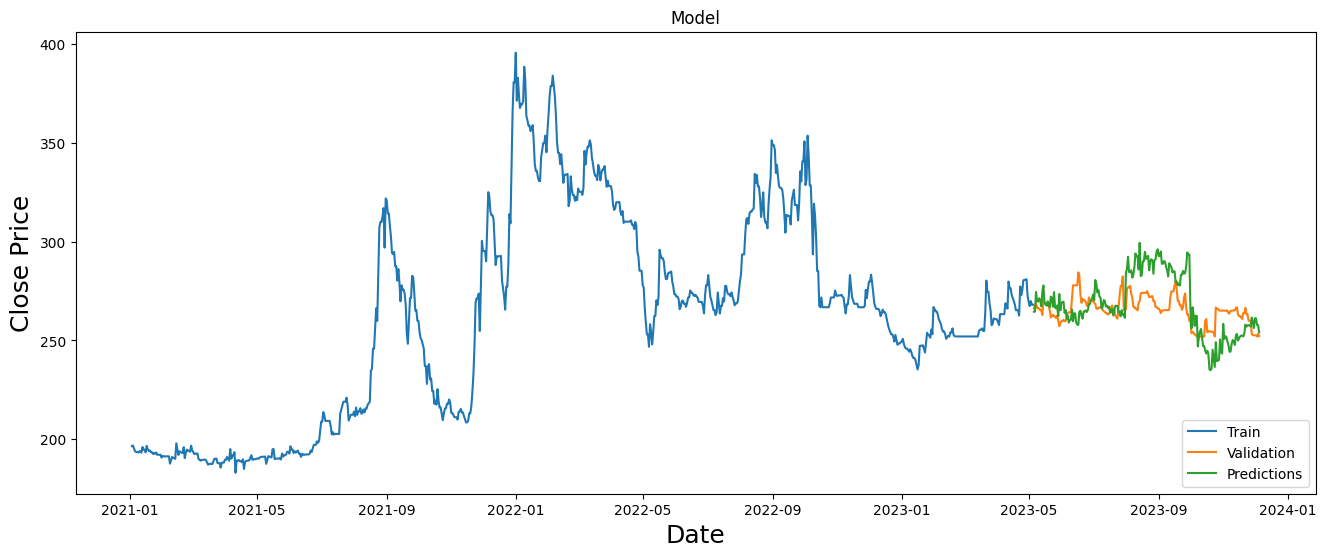

In [651]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

# With SMA_7, MACD, ema

Mean Squared Error: 10.460
Root Mean Squared Error: 3.234
R-squared Score: 0.774


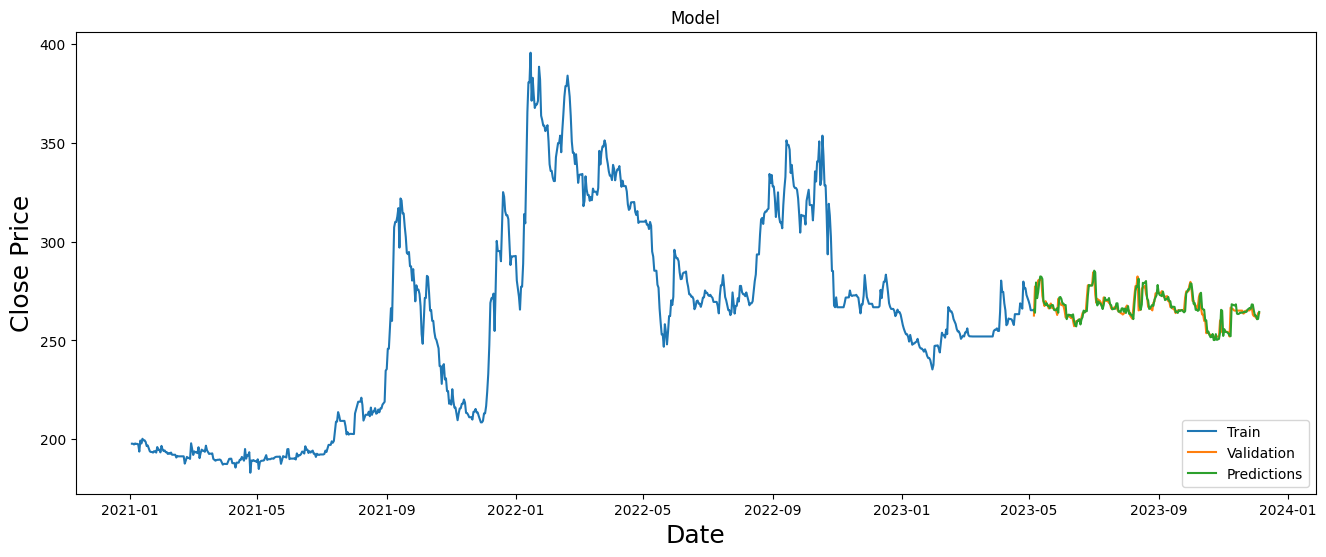

(10.459857458807589, 3.2341702890861495, 0.7742893540612807)

In [652]:
RfDF1 = Dataset.copy()
n_estimators = 70
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)

Mean Squared Error: 68.852
Root Mean Squared Error: 8.298
R-squared Score: -0.567


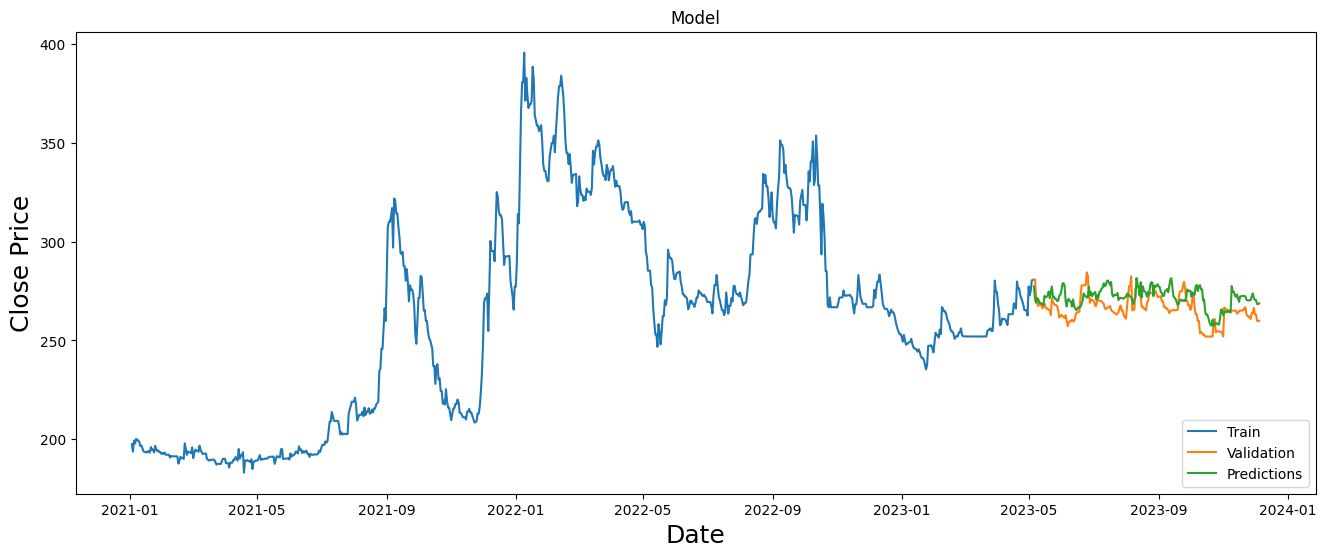

(68.85173605550813, 8.29769462293643, -0.5666907972141313)

In [653]:
RfDF7 = Dataset.copy()
n_estimators = 150
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

Mean Squared Error: 230.007
Root Mean Squared Error: 15.166
R-squared Score: -3.798


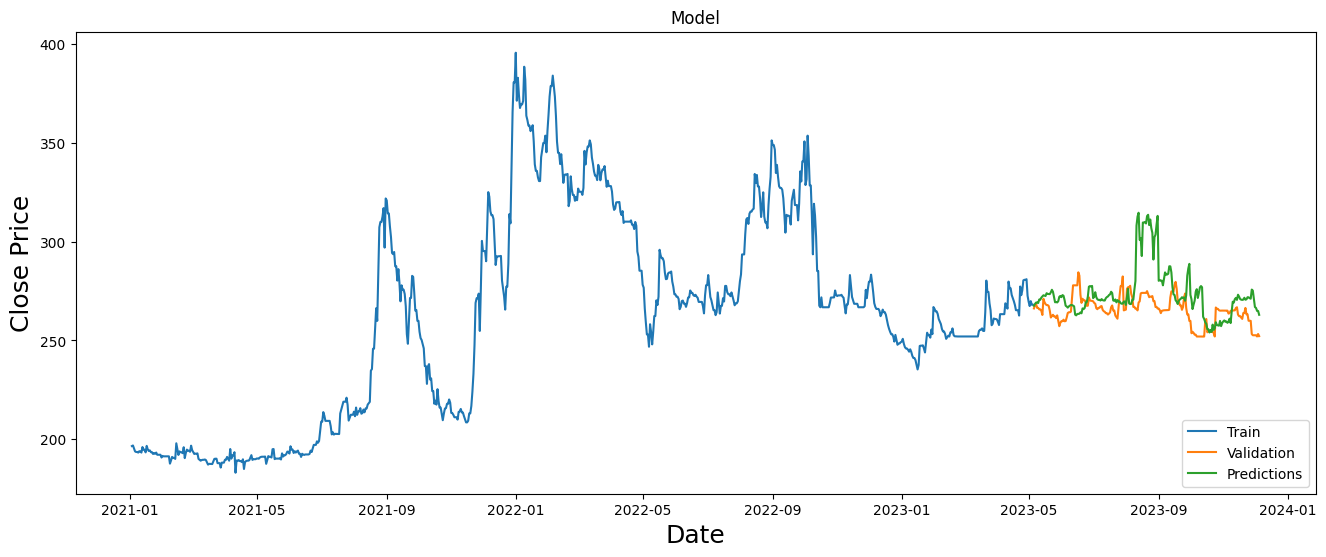

(230.00741510527902, 15.165995354914198, -3.7976031261308556)

In [656]:
RfDF15 = Dataset.copy()
n_estimators = 130
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

In [657]:
LDF1 = Dataset.copy()
epochs = 90
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)


['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_day
90
40
Epoch 1/90
22/22 - 3s - loss: 0.0297 - 3s/epoch - 122ms/step
Epoch 2/90
22/22 - 0s - loss: 0.0060 - 201ms/epoch - 9ms/step
Epoch 3/90
22/22 - 0s - loss: 0.0045 - 223ms/epoch - 10ms/step
Epoch 4/90
22/22 - 0s - loss: 0.0039 - 201ms/epoch - 9ms/step
Epoch 5/90
22/22 - 0s - loss: 0.0034 - 201ms/epoch - 9ms/step
Epoch 6/90
22/22 - 0s - loss: 0.0032 - 201ms/epoch - 9ms/step
Epoch 7/90
22/22 - 0s - loss: 0.0028 - 232ms/epoch - 11ms/step
Epoch 8/90
22/22 - 0s - loss: 0.0026 - 216ms/epoch - 10ms/step
Epoch 9/90
22/22 - 0s - loss: 0.0027 - 216ms/epoch - 10ms/step
Epoch 10/90
22/22 - 0s - loss: 0.0023 - 238ms/epoch - 11ms/step
Epoch 11/90
22/22 - 0s - loss: 0.0023 - 201ms/epoch - 9ms/step
Epoch 12/90
22/22 - 0s - loss: 0.0021 - 201ms/epoch - 9ms/step
Epoch 13/90
22/22 - 0s - loss: 0.0020 - 201ms/epoch - 9ms/step
Epoch 14/90
22/22 - 0s - loss: 0.0018 - 201ms/epoch - 9ms/step
Epoch 15/90
22/22 - 

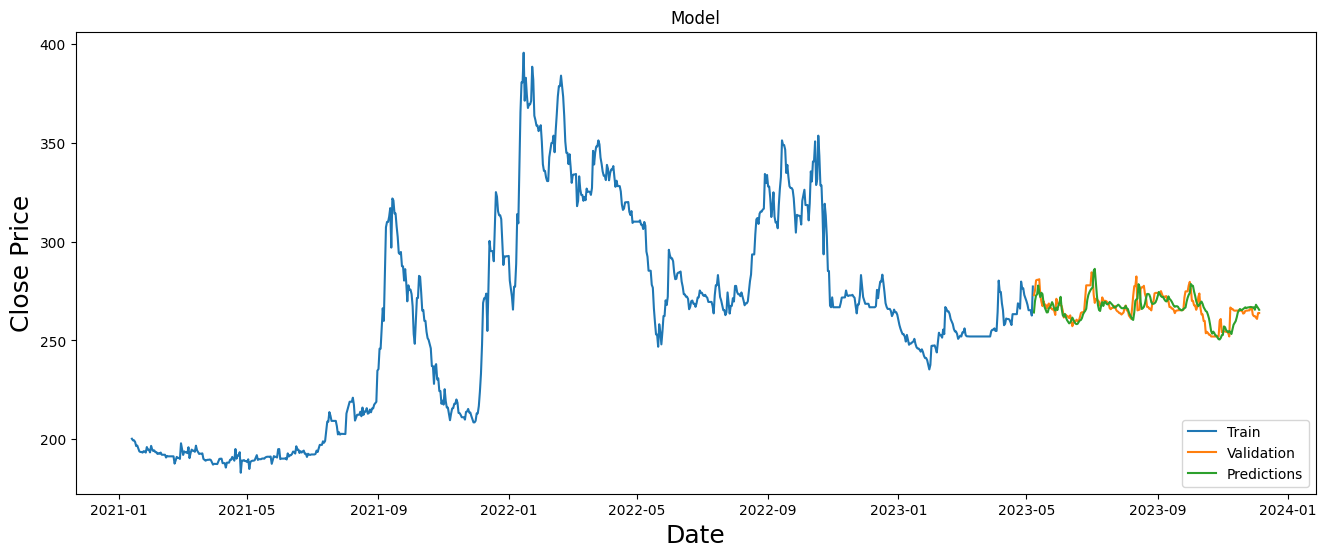

In [658]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [671]:
LDF7 = Dataset.copy()
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_week
120
40
Epoch 1/120
22/22 - 2s - loss: 0.0607 - 2s/epoch - 111ms/step
Epoch 2/120
22/22 - 0s - loss: 0.0153 - 188ms/epoch - 9ms/step
Epoch 3/120
22/22 - 0s - loss: 0.0118 - 188ms/epoch - 9ms/step
Epoch 4/120
22/22 - 0s - loss: 0.0105 - 184ms/epoch - 8ms/step
Epoch 5/120
22/22 - 0s - loss: 0.0102 - 188ms/epoch - 9ms/step
Epoch 6/120
22/22 - 0s - loss: 0.0098 - 188ms/epoch - 9ms/step
Epoch 7/120
22/22 - 0s - loss: 0.0093 - 188ms/epoch - 9ms/step
Epoch 8/120
22/22 - 0s - loss: 0.0092 - 192ms/epoch - 9ms/step
Epoch 9/120
22/22 - 0s - loss: 0.0087 - 188ms/epoch - 9ms/step
Epoch 10/120
22/22 - 0s - loss: 0.0083 - 196ms/epoch - 9ms/step
Epoch 11/120
22/22 - 0s - loss: 0.0077 - 188ms/epoch - 9ms/step
Epoch 12/120
22/22 - 0s - loss: 0.0071 - 184ms/epoch - 8ms/step
Epoch 13/120
22/22 - 0s - loss: 0.0065 - 188ms/epoch - 9ms/step
Epoch 14/120
22/22 - 0s - loss: 0.0063 - 188ms/epoch - 9ms/step
Epoch 15/

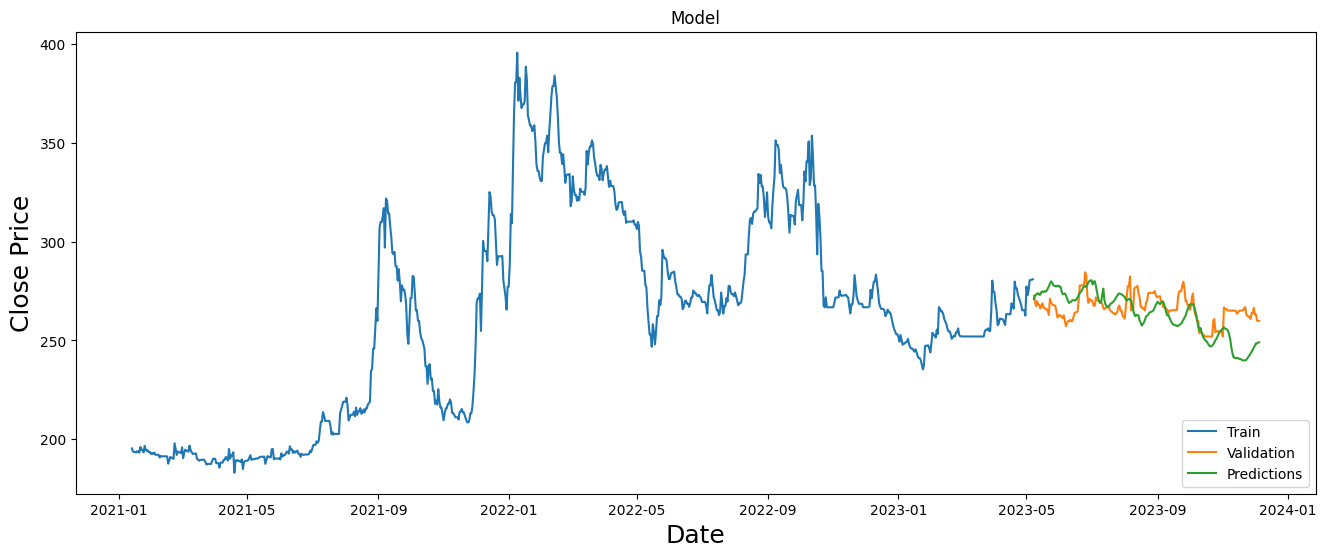

In [672]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [677]:
LDF15 = Dataset.copy()
epochs = 150
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
15_days
150
40
Epoch 1/150
22/22 - 2s - loss: 0.0408 - 2s/epoch - 113ms/step
Epoch 2/150
22/22 - 0s - loss: 0.0164 - 201ms/epoch - 9ms/step
Epoch 3/150
22/22 - 0s - loss: 0.0149 - 201ms/epoch - 9ms/step
Epoch 4/150
22/22 - 0s - loss: 0.0138 - 201ms/epoch - 9ms/step
Epoch 5/150
22/22 - 0s - loss: 0.0132 - 201ms/epoch - 9ms/step
Epoch 6/150
22/22 - 0s - loss: 0.0125 - 201ms/epoch - 9ms/step
Epoch 7/150
22/22 - 0s - loss: 0.0117 - 201ms/epoch - 9ms/step
Epoch 8/150
22/22 - 0s - loss: 0.0109 - 216ms/epoch - 10ms/step
Epoch 9/150
22/22 - 0s - loss: 0.0100 - 201ms/epoch - 9ms/step
Epoch 10/150
22/22 - 0s - loss: 0.0092 - 201ms/epoch - 9ms/step
Epoch 11/150
22/22 - 0s - loss: 0.0089 - 201ms/epoch - 9ms/step
Epoch 12/150
22/22 - 0s - loss: 0.0088 - 216ms/epoch - 10ms/step
Epoch 13/150
22/22 - 0s - loss: 0.0085 - 201ms/epoch - 9ms/step
Epoch 14/150
22/22 - 0s - loss: 0.0082 - 201ms/epoch - 9ms/step
Epoch 

22/22 - 0s - loss: 8.9449e-04 - 185ms/epoch - 8ms/step
Epoch 126/150
22/22 - 0s - loss: 6.3085e-04 - 201ms/epoch - 9ms/step
Epoch 127/150
22/22 - 0s - loss: 6.9510e-04 - 185ms/epoch - 8ms/step
Epoch 128/150
22/22 - 0s - loss: 0.0038 - 185ms/epoch - 8ms/step
Epoch 129/150
22/22 - 0s - loss: 0.0029 - 201ms/epoch - 9ms/step
Epoch 130/150
22/22 - 0s - loss: 0.0013 - 201ms/epoch - 9ms/step
Epoch 131/150
22/22 - 0s - loss: 0.0011 - 185ms/epoch - 8ms/step
Epoch 132/150
22/22 - 0s - loss: 8.6647e-04 - 201ms/epoch - 9ms/step
Epoch 133/150
22/22 - 0s - loss: 0.0015 - 201ms/epoch - 9ms/step
Epoch 134/150
22/22 - 0s - loss: 0.0013 - 201ms/epoch - 9ms/step
Epoch 135/150
22/22 - 0s - loss: 8.7939e-04 - 194ms/epoch - 9ms/step
Epoch 136/150
22/22 - 0s - loss: 7.0600e-04 - 185ms/epoch - 8ms/step
Epoch 137/150
22/22 - 0s - loss: 0.0011 - 201ms/epoch - 9ms/step
Epoch 138/150
22/22 - 0s - loss: 0.0010 - 185ms/epoch - 8ms/step
Epoch 139/150
22/22 - 0s - loss: 7.4610e-04 - 185ms/epoch - 8ms/step
Epoch 140/1

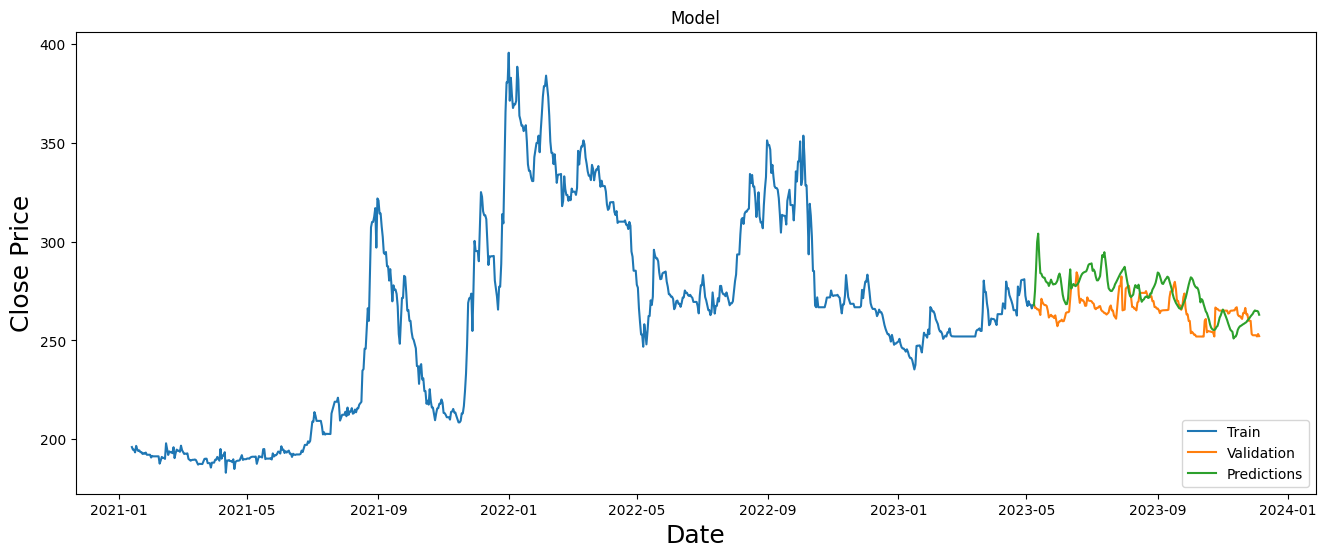

In [678]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# GRU

In [681]:
GDF1 = Dataset.copy()
epochs = 70
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_day
70
30
Epoch 1/70
29/29 [==============================] - 7s 16ms/step - loss: 0.0139
Epoch 2/70
29/29 [==============================] - 0s 16ms/step - loss: 0.0037
Epoch 3/70
29/29 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 4/70
29/29 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 5/70
29/29 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 6/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0020
Epoch 7/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 8/70
29/29 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 9/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0022
Epoch 10/70
29/29 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 11/70
29/29 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 12/70
29/

In [682]:
GDF7 = Dataset.copy()
epochs = 70
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_week
70
30
Epoch 1/70
29/29 [==============================] - 8s 17ms/step - loss: 0.0575
Epoch 2/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0109
Epoch 3/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0094
Epoch 4/70
29/29 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 5/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0089
Epoch 6/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0085
Epoch 7/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0086
Epoch 8/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0081
Epoch 9/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0078
Epoch 10/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0077
Epoch 11/70
29/29 [==============================] - 1s 17ms/step - loss: 0.0078
Epoch 12/70
29

In [683]:
GDF15 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
15_days
80
30
Epoch 1/80
29/29 [==============================] - 7s 17ms/step - loss: 0.0575
Epoch 2/80
29/29 [==============================] - 0s 17ms/step - loss: 0.0183
Epoch 3/80
29/29 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 4/80
29/29 [==============================] - 1s 17ms/step - loss: 0.0155
Epoch 5/80
29/29 [==============================] - 1s 17ms/step - loss: 0.0156
Epoch 6/80
29/29 [==============================] - 1s 17ms/step - loss: 0.0153
Epoch 7/80
29/29 [==============================] - 0s 16ms/step - loss: 0.0147
Epoch 8/80
29/29 [==============================] - 1s 17ms/step - loss: 0.0148
Epoch 9/80
29/29 [==============================] - 1s 17ms/step - loss: 0.0144
Epoch 10/80
29/29 [==============================] - 1s 17ms/step - loss: 0.0151
Epoch 11/80
29/29 [==============================] - 0s 17ms/step - loss: 0.0139
Epoch 12/80
2

# XGBoost

Mean Squared Error: 13.543294321715173
Root Mean Squared Error: 3.680121509096564
R-squared: 0.707752641799289


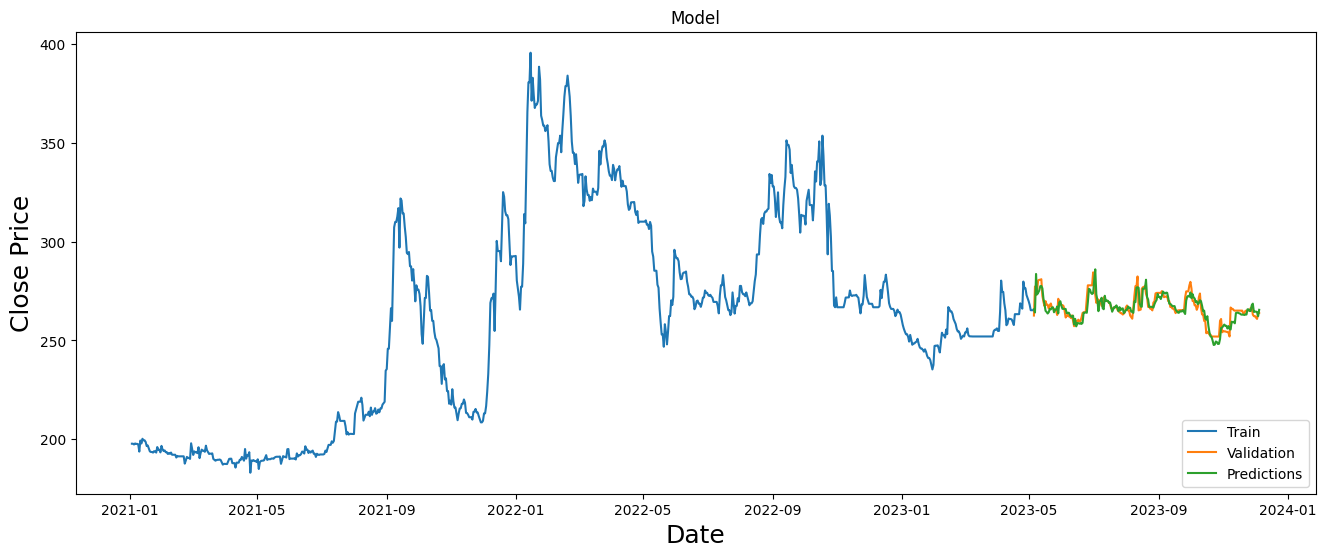

In [684]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

Mean Squared Error: 62.35113032952931
Root Mean Squared Error: 7.896273192432574
R-squared: -0.4187723894778643


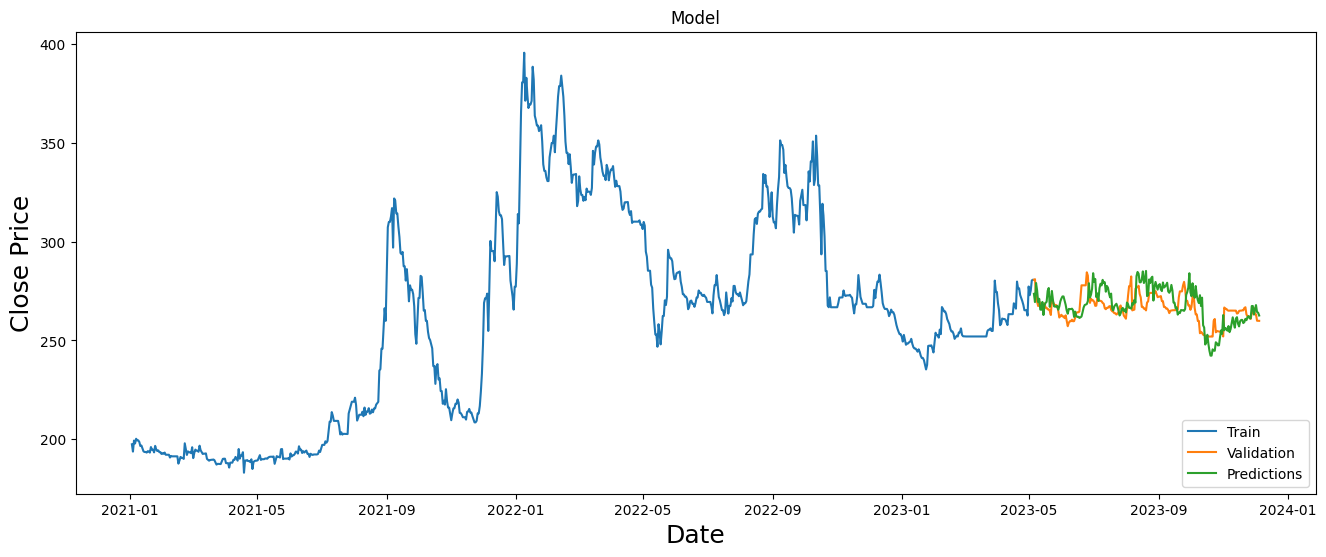

In [685]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

Mean Squared Error: 197.9720101608589
Root Mean Squared Error: 14.070252668692872
R-squared: -3.1293935432447153


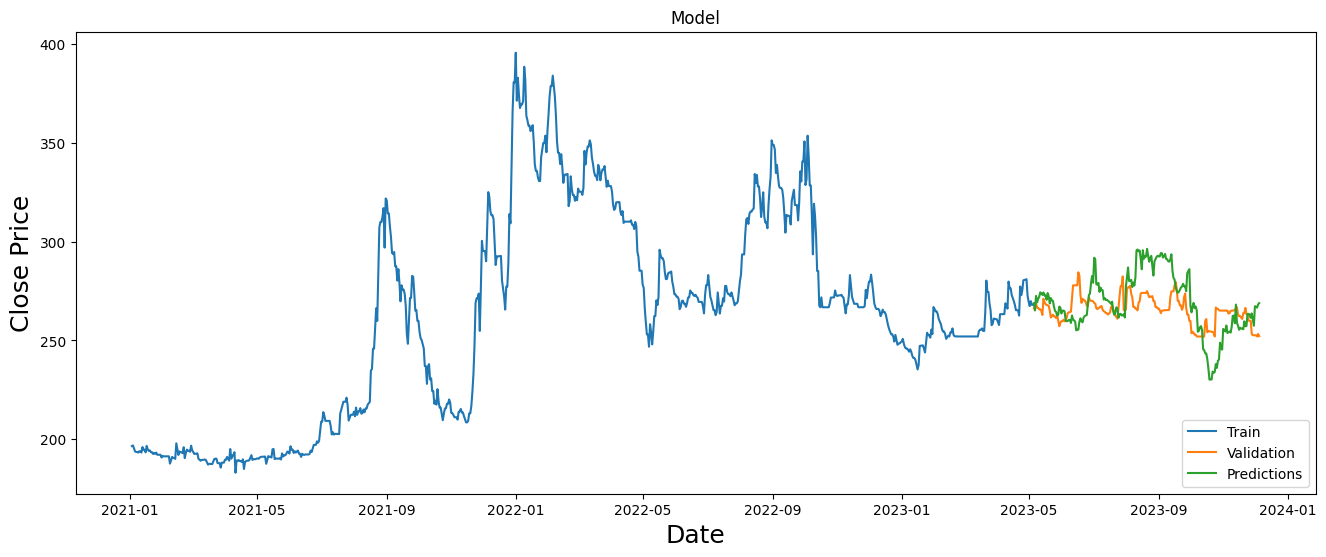

In [688]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

# Ensebled Algorithm

In [689]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,195.1,197.0,194.5,195.8,6809.0,3,1,2021,197.7,197.4,196.5,194.8,195.8,0.000000,0.000000,195.800000
1,2021-01-04,197.8,199.0,197.0,197.7,4473.0,4,1,2021,197.7,193.7,196.8,194.0,195.8,-0.151567,-0.030313,196.433333
2,2021-01-05,195.0,199.0,195.0,197.7,2974.0,5,1,2021,197.3,199.3,195.3,194.3,195.8,-0.268589,-0.077968,196.855556
3,2021-01-06,202.5,202.5,196.5,197.3,7801.0,6,1,2021,197.8,197.8,193.8,193.4,195.8,-0.325303,-0.127435,197.003704
4,2021-01-07,200.0,200.0,197.5,197.8,5833.0,7,1,2021,197.6,200.2,193.5,193.4,195.8,-0.405916,-0.183131,197.269136


In [690]:
def split_dataset(Feat, Tar, ran_state):
    Features = Feat
    Target = Tar
    random = ran_state
    X_train, X_test, y_train, y_test = train_test_split(
        Features,
        Target,
        test_size=0.2,
        random_state=random,
        shuffle=False
    )
    return X_train, X_test, y_train, y_test

In [691]:
def create_sequences(DF, sequence_length):
    X, y = [], []
    for i in range(len(DF) - sequence_length):
        X.append(DF[i:(i + sequence_length), :-1])
        y.append(DF[i + sequence_length, -1])
    X, y = np.array(X), np.array(y)
    return X, y.reshape(-1,1)

In [692]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt, mean, array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
import numpy as np

def LSTM_Model(X_train, X_test, y_train, epochs, batch_size, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :]
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    return y_pred_inv

def GRU_Model(X_train, X_test, y_train, epochs, batch_size, scaler):
    model = Sequential()
    model.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :]
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    return y_pred_inv

def random_forest_model(X_train, X_test, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def xgboost_model(X_train, X_test, y_train):
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def ensemble_model(EDF1, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state):
    from sklearn.metrics import mean_squared_error
    from numpy import sqrt, mean, array
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import xgboost as xgb
    from keras.models import Sequential
    from keras.layers import LSTM, GRU, Dense
    import numpy as np

    # Prepare and scale data
    scaler = MinMaxScaler()
    DF_scaled = scaler.fit_transform(EDF1[Features + [Target]])
    X_seq, y_seq = create_sequences(DF_scaled, sequence_length)

    X_train, X_test, y_train, y_test = split_dataset(X_seq, y_seq, random_state)
    X_train1, X_test1, y_train1, y_test1 = split_dataset(EDF1[Features], EDF1[Target], random_state)
    # Reshape for RF and XGB: taking the last timestep of each sequence
    X_train_last = X_train[:, -1, :]
    X_test_last = X_test[:, -1, :]
    
    # Train and predict with each model
    lstm_predictions = LSTM_Model(X_train, X_test, y_train, epochs, batch_size, scaler)
    gru_predictions = GRU_Model(X_train, X_test, y_train, epochs, batch_size, scaler)
    rf_predictions = random_forest_model(X_train1, X_test1, y_train1)
    xgb_predictions = xgboost_model(X_train1, X_test1,y_train1)
   
    # Inverse transform y_test and predictions to original scale
    # y_test_original = scaler.inverse_transform(np.concatenate((X_test_last, y_test), axis=1))[:, -1]
    # Ensure all predictions are in the original scale
    average_predictions = mean(array([lstm_predictions, gru_predictions, rf_predictions, xgb_predictions]), axis=0)
    # Calculate RMSE
    mse = mean_squared_error(y_test1, average_predictions)
    rmse = sqrt(mse)
    return rmse

In [693]:
EDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF1, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
22/22 - 2s - loss: 0.1328 - 2s/epoch - 108ms/step
Epoch 2/90
22/22 - 0s - loss: 0.0403 - 85ms/epoch - 4ms/step
Epoch 3/90
22/22 - 0s - loss: 0.0123 - 85ms/epoch - 4ms/step
Epoch 4/90
22/22 - 0s - loss: 0.0068 - 85ms/epoch - 4ms/step
Epoch 5/90
22/22 - 0s - loss: 0.0034 - 78ms/epoch - 4ms/step
Epoch 6/90
22/22 - 0s - loss: 0.0025 - 69ms/epoch - 3ms/step
Epoch 7/90
22/22 - 0s - loss: 0.0024 - 69ms/epoch - 3ms/step
Epoch 8/90
22/22 - 0s - loss: 0.0023 - 85ms/epoch - 4ms/step
Epoch 9/90
22/22 - 0s - loss: 0.0022 - 85ms/epoch - 4ms/step
Epoch 10/90
22/22 - 0s - loss: 0.0022 - 78ms/epoch - 4ms/step
Epoch 11/90
22/22 - 0s - loss: 0.0021 - 85ms/epoch - 4ms/step
Epoch 12/90
22/22 - 0s - loss: 0.0021 - 69ms/epoch - 3ms/step
Epoch 13/90
22/22 - 0s - loss: 0.0021 - 69ms/epoch - 3ms/step
Epoch 14/90
22/22 - 0s - loss: 0.0021 - 85ms/epoch - 4ms/step
Epoch 15/90
22/22 - 0s - loss: 0.0020 - 78ms/epoch - 4ms/step
Epoch 16/90
22/22 - 0s - loss: 0.0020 - 69ms/epoch - 3ms/step
Epoch 17/90
22/22

Epoch 43/90
22/22 - 0s - loss: 0.0016 - 69ms/epoch - 3ms/step
Epoch 44/90
22/22 - 0s - loss: 0.0015 - 78ms/epoch - 4ms/step
Epoch 45/90
22/22 - 0s - loss: 0.0015 - 69ms/epoch - 3ms/step
Epoch 46/90
22/22 - 0s - loss: 0.0015 - 85ms/epoch - 4ms/step
Epoch 47/90
22/22 - 0s - loss: 0.0015 - 69ms/epoch - 3ms/step
Epoch 48/90
22/22 - 0s - loss: 0.0015 - 78ms/epoch - 4ms/step
Epoch 49/90
22/22 - 0s - loss: 0.0015 - 85ms/epoch - 4ms/step
Epoch 50/90
22/22 - 0s - loss: 0.0015 - 69ms/epoch - 3ms/step
Epoch 51/90
22/22 - 0s - loss: 0.0015 - 69ms/epoch - 3ms/step
Epoch 52/90
22/22 - 0s - loss: 0.0014 - 100ms/epoch - 5ms/step
Epoch 53/90
22/22 - 0s - loss: 0.0015 - 195ms/epoch - 9ms/step
Epoch 54/90
22/22 - 0s - loss: 0.0015 - 78ms/epoch - 4ms/step
Epoch 55/90
22/22 - 0s - loss: 0.0014 - 85ms/epoch - 4ms/step
Epoch 56/90
22/22 - 0s - loss: 0.0014 - 69ms/epoch - 3ms/step
Epoch 57/90
22/22 - 0s - loss: 0.0014 - 132ms/epoch - 6ms/step
Epoch 58/90
22/22 - 0s - loss: 0.0014 - 85ms/epoch - 4ms/step
Epoch

In [694]:
EDF2 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF2, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
22/22 - 3s - loss: 0.1210 - 3s/epoch - 117ms/step
Epoch 2/90
22/22 - 0s - loss: 0.0351 - 69ms/epoch - 3ms/step
Epoch 3/90
22/22 - 0s - loss: 0.0170 - 85ms/epoch - 4ms/step
Epoch 4/90
22/22 - 0s - loss: 0.0120 - 94ms/epoch - 4ms/step
Epoch 5/90
22/22 - 0s - loss: 0.0097 - 78ms/epoch - 4ms/step
Epoch 6/90
22/22 - 0s - loss: 0.0089 - 69ms/epoch - 3ms/step
Epoch 7/90
22/22 - 0s - loss: 0.0087 - 69ms/epoch - 3ms/step
Epoch 8/90
22/22 - 0s - loss: 0.0086 - 85ms/epoch - 4ms/step
Epoch 9/90
22/22 - 0s - loss: 0.0084 - 85ms/epoch - 4ms/step
Epoch 10/90
22/22 - 0s - loss: 0.0084 - 78ms/epoch - 4ms/step
Epoch 11/90
22/22 - 0s - loss: 0.0083 - 69ms/epoch - 3ms/step
Epoch 12/90
22/22 - 0s - loss: 0.0082 - 69ms/epoch - 3ms/step
Epoch 13/90
22/22 - 0s - loss: 0.0082 - 85ms/epoch - 4ms/step
Epoch 14/90
22/22 - 0s - loss: 0.0081 - 85ms/epoch - 4ms/step
Epoch 15/90
22/22 - 0s - loss: 0.0082 - 78ms/epoch - 4ms/step
Epoch 16/90
22/22 - 0s - loss: 0.0078 - 85ms/epoch - 4ms/step
Epoch 17/90
22/22

Epoch 43/90
22/22 - 0s - loss: 0.0063 - 85ms/epoch - 4ms/step
Epoch 44/90
22/22 - 0s - loss: 0.0061 - 78ms/epoch - 4ms/step
Epoch 45/90
22/22 - 0s - loss: 0.0059 - 78ms/epoch - 4ms/step
Epoch 46/90
22/22 - 0s - loss: 0.0058 - 85ms/epoch - 4ms/step
Epoch 47/90
22/22 - 0s - loss: 0.0060 - 69ms/epoch - 3ms/step
Epoch 48/90
22/22 - 0s - loss: 0.0058 - 85ms/epoch - 4ms/step
Epoch 49/90
22/22 - 0s - loss: 0.0057 - 85ms/epoch - 4ms/step
Epoch 50/90
22/22 - 0s - loss: 0.0056 - 78ms/epoch - 4ms/step
Epoch 51/90
22/22 - 0s - loss: 0.0055 - 85ms/epoch - 4ms/step
Epoch 52/90
22/22 - 0s - loss: 0.0057 - 69ms/epoch - 3ms/step
Epoch 53/90
22/22 - 0s - loss: 0.0057 - 69ms/epoch - 3ms/step
Epoch 54/90
22/22 - 0s - loss: 0.0057 - 85ms/epoch - 4ms/step
Epoch 55/90
22/22 - 0s - loss: 0.0055 - 78ms/epoch - 4ms/step
Epoch 56/90
22/22 - 0s - loss: 0.0054 - 85ms/epoch - 4ms/step
Epoch 57/90
22/22 - 0s - loss: 0.0055 - 69ms/epoch - 3ms/step
Epoch 58/90
22/22 - 0s - loss: 0.0053 - 69ms/epoch - 3ms/step
Epoch 59

In [695]:
EDF3 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF3, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
22/22 - 3s - loss: 0.1154 - 3s/epoch - 115ms/step
Epoch 2/90
22/22 - 0s - loss: 0.0311 - 85ms/epoch - 4ms/step
Epoch 3/90
22/22 - 0s - loss: 0.0199 - 85ms/epoch - 4ms/step
Epoch 4/90
22/22 - 0s - loss: 0.0182 - 78ms/epoch - 4ms/step
Epoch 5/90
22/22 - 0s - loss: 0.0171 - 85ms/epoch - 4ms/step
Epoch 6/90
22/22 - 0s - loss: 0.0163 - 69ms/epoch - 3ms/step
Epoch 7/90
22/22 - 0s - loss: 0.0160 - 69ms/epoch - 3ms/step
Epoch 8/90
22/22 - 0s - loss: 0.0159 - 85ms/epoch - 4ms/step
Epoch 9/90
22/22 - 0s - loss: 0.0157 - 85ms/epoch - 4ms/step
Epoch 10/90
22/22 - 0s - loss: 0.0156 - 78ms/epoch - 4ms/step
Epoch 11/90
22/22 - 0s - loss: 0.0156 - 69ms/epoch - 3ms/step
Epoch 12/90
22/22 - 0s - loss: 0.0154 - 85ms/epoch - 4ms/step
Epoch 13/90
22/22 - 0s - loss: 0.0153 - 85ms/epoch - 4ms/step
Epoch 14/90
22/22 - 0s - loss: 0.0152 - 78ms/epoch - 4ms/step
Epoch 15/90
22/22 - 0s - loss: 0.0150 - 69ms/epoch - 3ms/step
Epoch 16/90
22/22 - 0s - loss: 0.0149 - 85ms/epoch - 4ms/step
Epoch 17/90
22/22

Epoch 43/90
22/22 - 0s - loss: 0.0105 - 85ms/epoch - 4ms/step
Epoch 44/90
22/22 - 0s - loss: 0.0107 - 63ms/epoch - 3ms/step
Epoch 45/90
22/22 - 0s - loss: 0.0106 - 69ms/epoch - 3ms/step
Epoch 46/90
22/22 - 0s - loss: 0.0104 - 69ms/epoch - 3ms/step
Epoch 47/90
22/22 - 0s - loss: 0.0103 - 78ms/epoch - 4ms/step
Epoch 48/90
22/22 - 0s - loss: 0.0102 - 69ms/epoch - 3ms/step
Epoch 49/90
22/22 - 0s - loss: 0.0107 - 69ms/epoch - 3ms/step
Epoch 50/90
22/22 - 0s - loss: 0.0101 - 69ms/epoch - 3ms/step
Epoch 51/90
22/22 - 0s - loss: 0.0102 - 63ms/epoch - 3ms/step
Epoch 52/90
22/22 - 0s - loss: 0.0100 - 85ms/epoch - 4ms/step
Epoch 53/90
22/22 - 0s - loss: 0.0099 - 69ms/epoch - 3ms/step
Epoch 54/90
22/22 - 0s - loss: 0.0100 - 62ms/epoch - 3ms/step
Epoch 55/90
22/22 - 0s - loss: 0.0097 - 69ms/epoch - 3ms/step
Epoch 56/90
22/22 - 0s - loss: 0.0097 - 69ms/epoch - 3ms/step
Epoch 57/90
22/22 - 0s - loss: 0.0097 - 62ms/epoch - 3ms/step
Epoch 58/90
22/22 - 0s - loss: 0.0095 - 85ms/epoch - 4ms/step
Epoch 59